# Проект: классификация

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [49]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [50]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код

# Количество пропусков в каждом столбце
missing_counts = df.isnull().sum()
print("Количество пропусков в каждом столбце:")
print(missing_counts)

Количество пропусков в каждом столбце:
age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64


### Задание 2

In [51]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код

df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [52]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

# Функция для очистки и преобразования balance в float
def convert_balance(balance):
    # Преобразование balance в строку
    balance = str(balance)
    # Удаление знаков доллара и пробелов
    balance = balance.replace('$', '').replace(' ', '')
    # Замена запятых на точки для преобразования в десятичный формат
    balance = balance.replace(',', '.')
    try:
        # Преобразование в float
        return float(balance)
    except ValueError:
        return None # или обработать ошибку по-другому, если необходимо

# Применение функции преобразования к столбцу balance
df['balance'] = df['balance'].apply(convert_balance)

#Вычисляю среднее значение и вывожу ответ до трех знаков после запятой
round(df['balance'].mean(),3)

1529.129

### Задание 4

In [53]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код

# Заполнение пропусков медианным значением
median_value = df['balance'].median()
df['balance'] = df['balance'].fillna(median_value)

#Вычисляю среднее значение и вывожу ответ до трех знаков после запятой
round(df['balance'].mean(),3)


1526.936

### Задание 5

In [54]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код

# Определение пропущенных значений как 'unknown'
missing_value = 'unknown'

# Замена пропущенных значений в признаке job
mode_job = df['job'].mode()[0]  # Находим моду для job
df['job'] = df['job'].replace(missing_value, mode_job)  # Заменяем пропущенные значения на моду

# Замена пропущенных значений в признаке education
mode_education = df['education'].mode()[0]  # Находим моду для education
df['education'] = df['education'].replace(missing_value, mode_education)  # Заменяем пропущенные значения на моду

In [55]:
# Функция для очистки и преобразования balance в float
def convert_balance(balance):
    # Преобразование balance в строку
    balance = str(balance)
    # Удаление знаков доллара и пробелов
    balance = balance.replace('$', '').replace(' ', '')
    # Замена запятых на точки для преобразования в десятичный формат
    balance = balance.replace(',', '.')
    try:
        # Преобразование в float
        return float(balance)
    except ValueError:
        return None  # или обработать ошибку по-другому, если необходимо

# Применение функции преобразования к столбцу balance
df['balance'] = df['balance'].apply(convert_balance)

# Фильтрация данных для самых популярных job и education
filtered_df = df[(df['job'] == mode_job) & (df['education'] == mode_education)]

# Расчет среднего баланса
average_balance = filtered_df['balance'].mean()

# Округление до трех знаков после запятой
average_balance_rounded = round(average_balance, 3)

print(average_balance_rounded)


1598.883


### Задание 6

In [56]:
def outliers_iqr_mod_2(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x> upper_bound)]
    # outliers = data[(x<=lower_bound) | (x>= upper_bound)]
    # cleaned = data[(x>lower_bound) & (x < upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)] 
    return outliers, cleaned,lower_bound, upper_bound

outliers, cleaned,lower_bound, upper_bound = outliers_iqr_mod_2(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Нижняя граница: {lower_bound}')
print(f'Верхняя граница: {upper_bound}')


# Перезапись df очищенными данными
df = cleaned

# Проверка
print(f'Число строк после удаления выбросов: {df.shape[0]}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Нижняя граница: -2241.0
Верхняя граница: 4063.0
Число строк после удаления выбросов: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

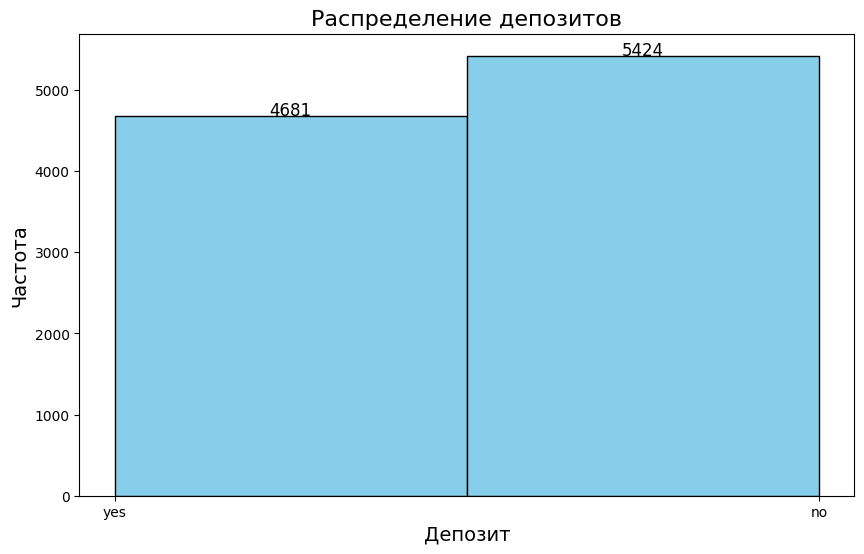

In [57]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код

# Создание фигуры и осей
plt.figure(figsize=(10, 6))

# Построение гистограммы
counts, bins, patches = plt.hist(df['deposit'], bins=2, color='skyblue', edgecolor='black')

# Настройка заголовка и меток осей
plt.title('Распределение депозитов', fontsize=16)
plt.xlabel('Депозит', fontsize=14)
plt.ylabel('Частота', fontsize=14)

# Добавление значений на столбцы
for count, patch in zip(counts, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2., height + 5, int(count), ha='center', fontsize=12, color='black')

# Показать график
plt.show()


### Задания 2 и 3

In [58]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

df['age'].max()

df['duration'].min()

2

### Задания 4 и 5

<Axes: >

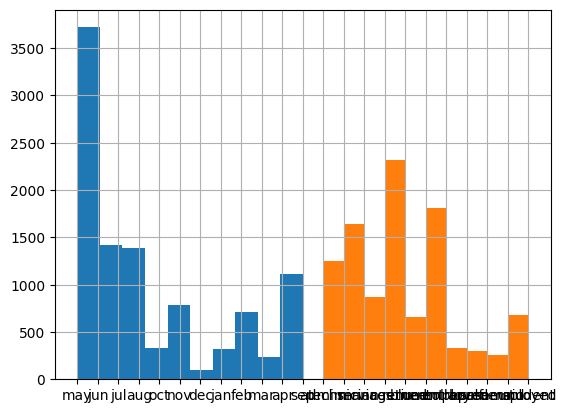

In [59]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

df['month'].hist()

df['job'].hist()

### Задание 6

In [60]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

poup = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
poup



deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


### Задание 7

In [61]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

false_mounth = df.groupby("month")['deposit'].value_counts(normalize=False).unstack()
false_mounth

deposit,no,yes
month,,
apr,317,513
aug,775,610
dec,9,84
feb,323,386
jan,194,125
jul,836,582
jun,606,498
mar,24,213
may,1776,841


### Задание 8

age_category
<30      1455
30-40    3961
40-50    2382
50-60    1654
60+       653
Name: count, dtype: int64


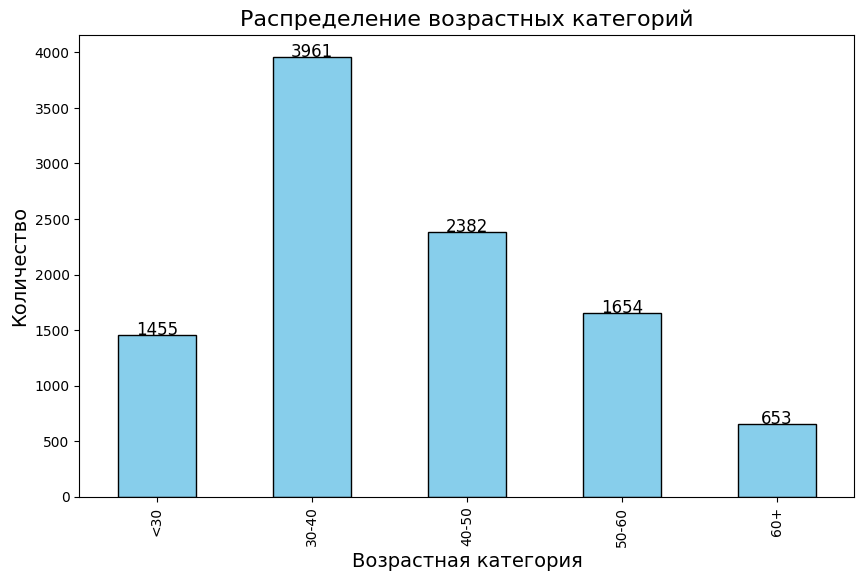

In [62]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения


# Преобразование возраста в категории
df['age_category'] = pd.cut(df['age'], 
                            bins=[0, 30, 40, 50, 60, float('inf')], 
                            labels=['<30', '30-40', '40-50', '50-60', '60+'], 
                            right=False)

# Создание сводной таблицы
age_category_counts = df['age_category'].value_counts().sort_index()

# Печать сводной таблицы
print(age_category_counts)

# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
age_category_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Настройка заголовка и меток осей
plt.title('Распределение возрастных категорий', fontsize=16)
plt.xlabel('Возрастная категория', fontsize=14)
plt.ylabel('Количество', fontsize=14)

# Показать значения на столбцах
for i, count in enumerate(age_category_counts):
    plt.text(i, count + 0.2, str(count), ha='center', fontsize=12)

# Показать график
plt.show()


### Задания 9 и 10

---

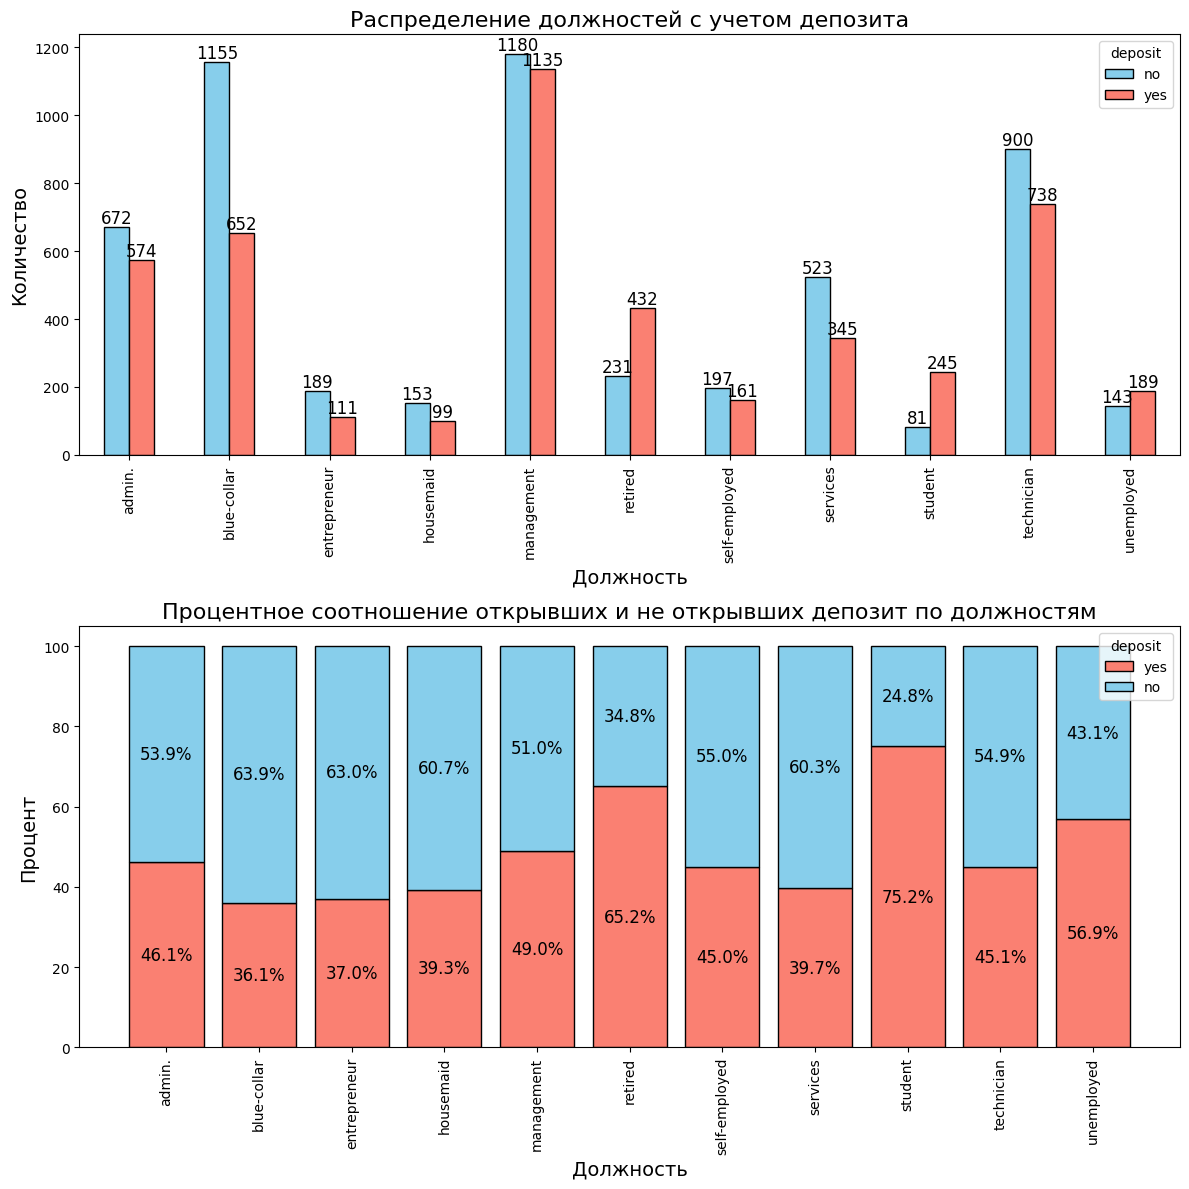

In [63]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

# Создание сводной таблицы для первого графика
pivot_table = df.pivot_table(index='job', columns='deposit', aggfunc='size', fill_value=0)

# Подсчет общего количества людей для каждой должности
total_counts = df['job'].value_counts()

# Подсчет количества людей с открытым депозитом для каждой должности
deposit_counts = df[df['deposit'] == 'yes']['job'].value_counts()

# Подсчет количества людей без депозита для каждой должности
no_deposit_counts = df[df['deposit'] == 'no']['job'].value_counts()

# Вычисление процентного соотношения
percentage_deposit = (deposit_counts / total_counts) * 100
percentage_no_deposit = 100 - percentage_deposit

# Преобразование в DataFrame для удобства
percentage_deposit_df = percentage_deposit.reset_index()
percentage_deposit_df.columns = ['job', 'percentage_deposit']

percentage_no_deposit_df = percentage_no_deposit.reset_index()
percentage_no_deposit_df.columns = ['job', 'percentage_no_deposit']

# Объединение данных для построения стека
combined_df = pd.merge(percentage_deposit_df, percentage_no_deposit_df, on='job')

# Создание графиков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Первый график - количество людей по должностям с разделением по депозиту
pivot_table.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_title('Распределение должностей с учетом депозита', fontsize=16)
axes[0].set_xlabel('Должность', fontsize=14)
axes[0].set_ylabel('Количество', fontsize=14)
axes[0].legend(title='deposit')
axes[0].tick_params(axis='x', rotation=90)
for container in axes[0].containers:
    axes[0].bar_label(container, label_type='edge', fontsize=12)

# Второй график - процентное соотношение открывших и не открывших депозит по должностям
axes[1].bar(combined_df['job'], combined_df['percentage_deposit'], color='salmon', edgecolor='black', label='yes')
axes[1].bar(combined_df['job'], combined_df['percentage_no_deposit'], bottom=combined_df['percentage_deposit'], color='skyblue', edgecolor='black', label='no')
axes[1].set_title('Процентное соотношение открывших и не открывших депозит по должностям', fontsize=16)
axes[1].set_xlabel('Должность', fontsize=14)
axes[1].set_ylabel('Процент', fontsize=14)
axes[1].legend(title='deposit')
axes[1].tick_params(axis='x', rotation=90)
for i in range(len(combined_df)):
    axes[1].text(i, combined_df['percentage_deposit'][i] / 2, f'{combined_df["percentage_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)
    axes[1].text(i, combined_df['percentage_deposit'][i] + combined_df['percentage_no_deposit'][i] / 2, f'{combined_df["percentage_no_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)

# Показать графики
plt.tight_layout()
plt.show()


Если смотреть на грфик, то сначала будем отмечать, те проффессии, которые имеют больший поенциал для нас в будущем, а это:
 

Имя | Процент | МСН
|--|--|--|
student | 75.2% | H
retired | 65.2% | C
unemployed | 56.9% | H
management | 49.0% | M


*мсн - много, среднее, н (мало) - количество людей в самой должности по отношению у другим профессиям

Далее я пока не буду расписывать. Возьму эти 4 группы для дальнейшего подбора в сфере поиска уникального клиента для депозита. Были взяты текущие профессии по причине их большего влияния в % эквиваленте. 

Есть визуализационная закономерность, когда банк работает с одной из групп в большей части, то большая его клиентов оказываются без депозита. Соотвенно группы для анализа взяты те, что меньше состовляют по количеству и в дальнейшем надеюсь найти ту саммую группу, на которую банку стоит акцентировать внимание. 

### balance

In [64]:
df['balance'].describe()

count    10105.000000
mean       807.653538
std        994.151966
min      -2049.000000
25%         95.000000
50%        445.000000
75%       1227.000000
max       4063.000000
Name: balance, dtype: float64

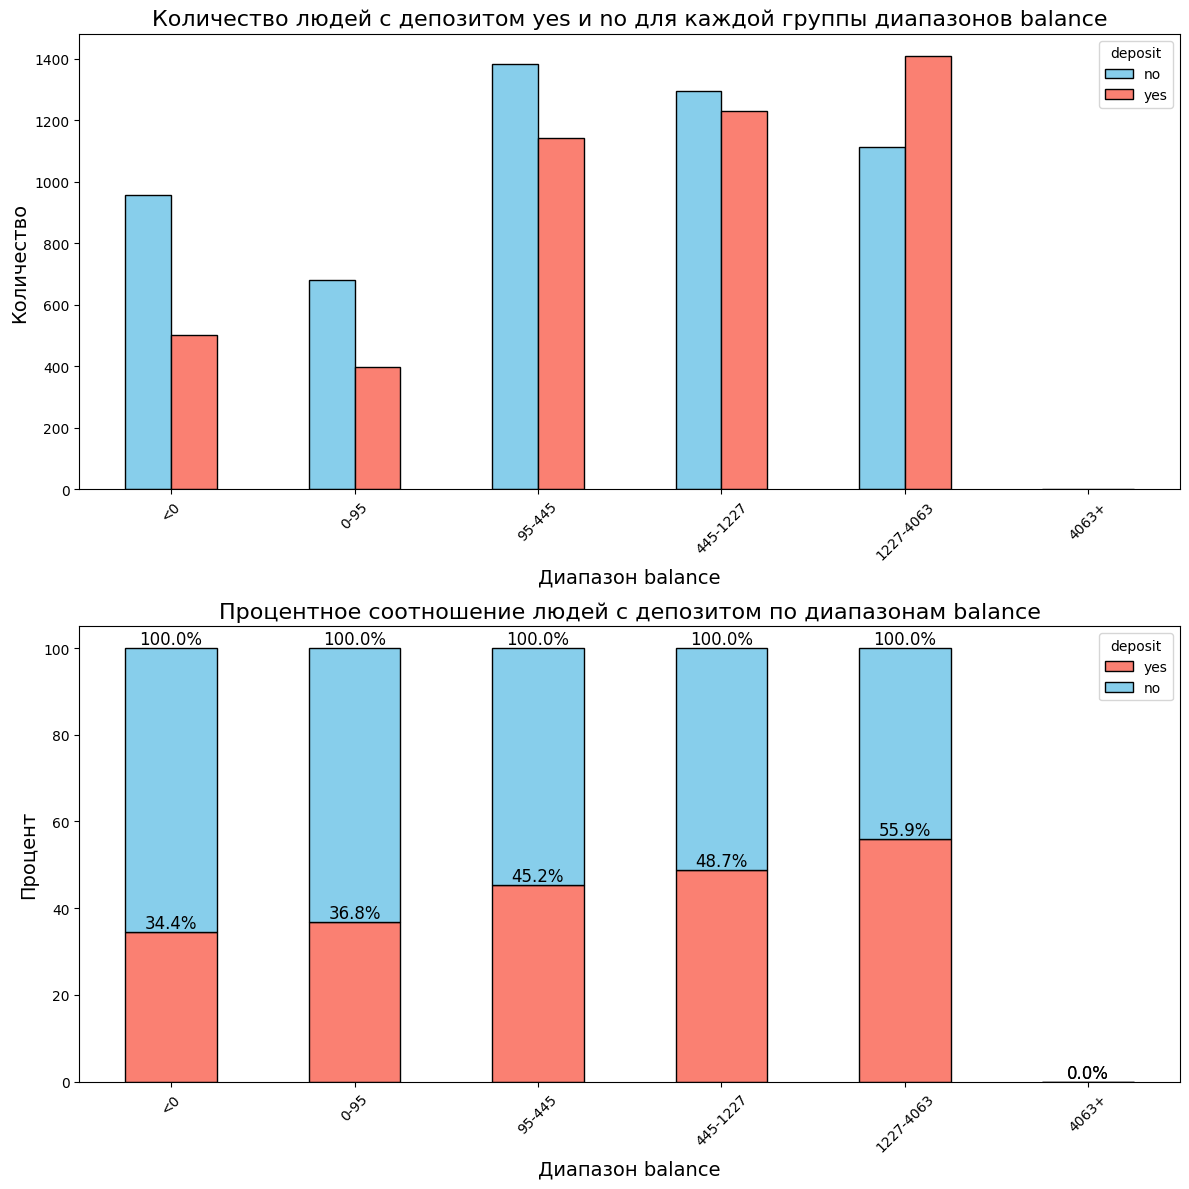

In [65]:


# Разделение balance на диапазоны, учитывая статистические данные
balance_bins = pd.cut(df['balance'], bins=[-2050, 0, 95, 445, 1227, 4063, 4500], 
                      labels=['<0', '0-95', '95-445', '445-1227', '1227-4063', '4063+'])


# # Разделение balance на диапазоны, учитывая статистические данные
# balance_bins = pd.cut(df['balance'], bins=[-2050, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500], 
#                       labels=['<0', '0-500', '500-1000', '1000-1500', '1500-2000', '2000-2500', '2500-3000', '3000-3500', '3500-4000', '4000+'])


# Группировка данных по 'balance_bins' и 'deposit' для подсчета количества (count) в каждой категории
grouped_balance_deposit = df.groupby([balance_bins, 'deposit']).size().unstack(fill_value=0)

# Создание сводной таблицы для процентного соотношения по диапазонам balance
balance_deposit_counts = df.groupby([balance_bins, 'deposit']).size().unstack(fill_value=0)
balance_deposit_percentages = (balance_deposit_counts.div(balance_deposit_counts.sum(axis=1), axis=0) * 100).reset_index()

# Пересортировка столбцов, чтобы "yes" был первым
balance_deposit_percentages = balance_deposit_percentages[['balance', 'yes', 'no']]

# Создание графиков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Верхний график - количество людей с депозитом yes и no для каждой группы диапазонов balance
grouped_balance_deposit.plot(kind='bar', stacked=False, ax=axes[0], color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_title('Количество людей с депозитом yes и no для каждой группы диапазонов balance', fontsize=16)
axes[0].set_xlabel('Диапазон balance', fontsize=14)
axes[0].set_ylabel('Количество', fontsize=14)
axes[0].legend(title='deposit', loc='upper right')
axes[0].tick_params(axis='x', rotation=45)

# Нижний график - процентное соотношение людей с депозитом для каждого диапазона balance
balance_deposit_percentages.plot(kind='bar', x='balance', stacked=True, color=['salmon', 'skyblue'], edgecolor='black', ax=axes[1])
axes[1].set_title('Процентное соотношение людей с депозитом по диапазонам balance', fontsize=16)
axes[1].set_xlabel('Диапазон balance', fontsize=14)
axes[1].set_ylabel('Процент', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
for container in axes[1].containers:
    axes[1].bar_label(container, label_type='edge', fontsize=12, fmt='%.1f%%')

# Показать графики
plt.tight_layout()
plt.show()



balance - следующий признак 

Имя | Процент | MCH
|--|--|--|
1227-4063 | 55.9% | M

Берем одну категорию, так как во всех остальных случаев приоблодает больше отказов, чем положителных депозитов


### marital

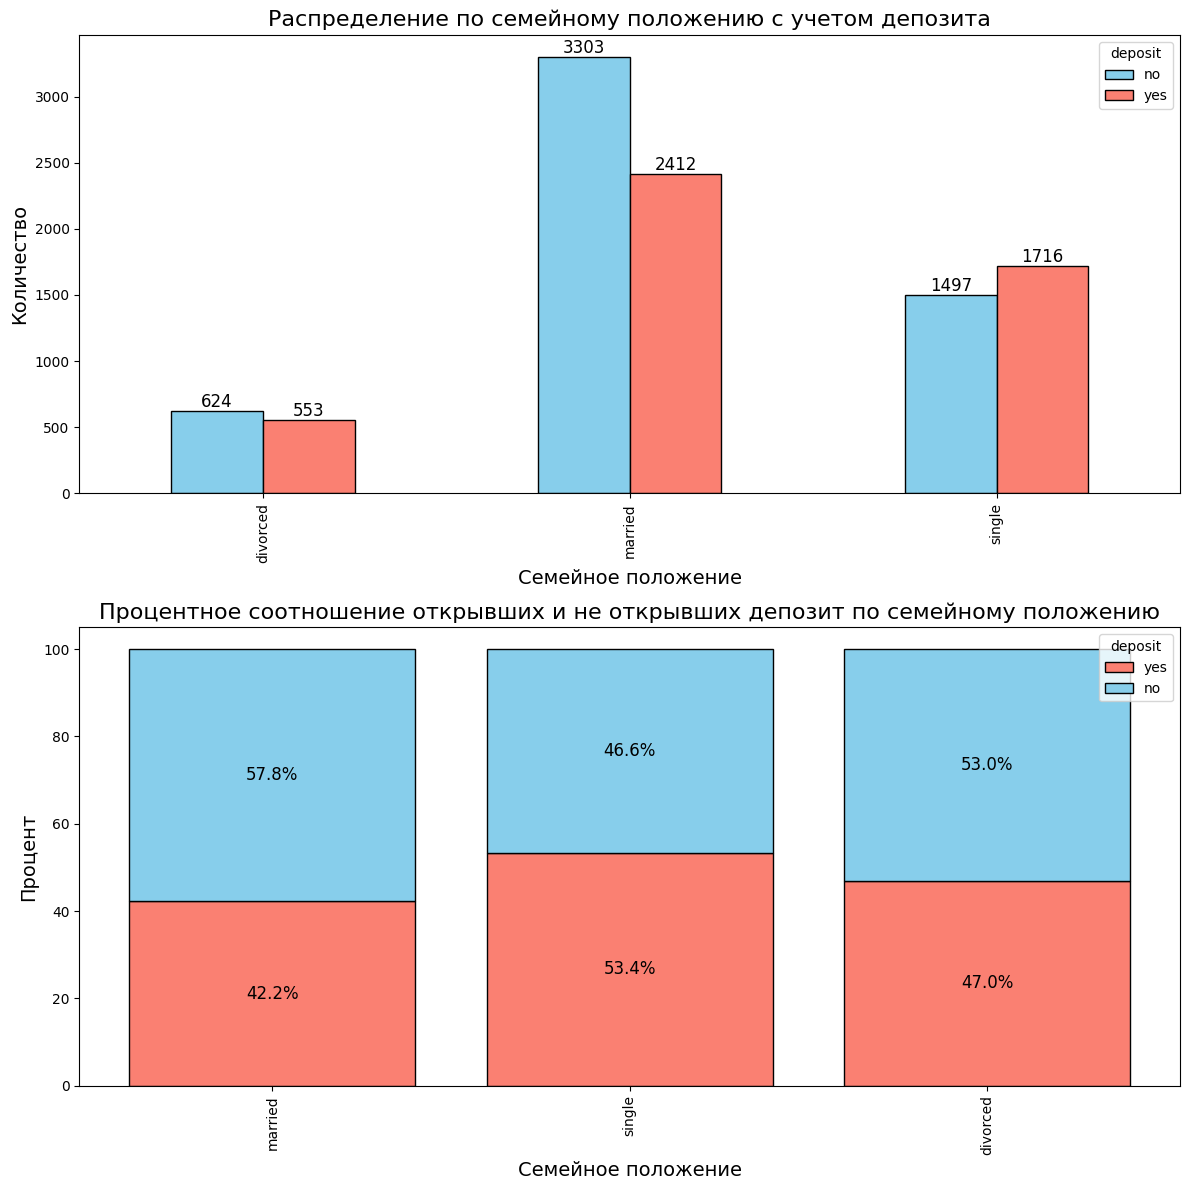

In [66]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

# Создание сводной таблицы для первого графика
pivot_table = df.pivot_table(index='marital', columns='deposit', aggfunc='size', fill_value=0)

# Подсчет общего количества людей для каждой категории marital
total_counts = df['marital'].value_counts()

# Подсчет количества людей с открытым депозитом для каждой категории marital
deposit_counts = df[df['deposit'] == 'yes']['marital'].value_counts()

# Подсчет количества людей без депозита для каждой категории marital
no_deposit_counts = df[df['deposit'] == 'no']['marital'].value_counts()

# Вычисление процентного соотношения
percentage_deposit = (deposit_counts / total_counts) * 100
percentage_no_deposit = 100 - percentage_deposit

# Преобразование в DataFrame для удобства
percentage_deposit_df = percentage_deposit.reset_index()
percentage_deposit_df.columns = ['marital', 'percentage_deposit']

percentage_no_deposit_df = percentage_no_deposit.reset_index()
percentage_no_deposit_df.columns = ['marital', 'percentage_no_deposit']

# Объединение данных для построения стека
combined_df = pd.merge(percentage_deposit_df, percentage_no_deposit_df, on='marital')

# Создание графиков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Первый график - количество людей по категориям marital с разделением по депозиту
pivot_table.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_title('Распределение по семейному положению с учетом депозита', fontsize=16)
axes[0].set_xlabel('Семейное положение', fontsize=14)
axes[0].set_ylabel('Количество', fontsize=14)
axes[0].legend(title='deposit')
axes[0].tick_params(axis='x', rotation=90)
for container in axes[0].containers:
    axes[0].bar_label(container, label_type='edge', fontsize=12)

# Второй график - процентное соотношение открывших и не открывших депозит по категориям marital
axes[1].bar(combined_df['marital'], combined_df['percentage_deposit'], color='salmon', edgecolor='black', label='yes')
axes[1].bar(combined_df['marital'], combined_df['percentage_no_deposit'], bottom=combined_df['percentage_deposit'], color='skyblue', edgecolor='black', label='no')
axes[1].set_title('Процентное соотношение открывших и не открывших депозит по семейному положению', fontsize=16)
axes[1].set_xlabel('Семейное положение', fontsize=14)
axes[1].set_ylabel('Процент', fontsize=14)
axes[1].legend(title='deposit')
axes[1].tick_params(axis='x', rotation=90)
for i in range(len(combined_df)):
    axes[1].text(i, combined_df['percentage_deposit'][i] / 2, f'{combined_df["percentage_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)
    axes[1].text(i, combined_df['percentage_deposit'][i] + combined_df['percentage_no_deposit'][i] / 2, f'{combined_df["percentage_no_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)

# Показать графики
plt.tight_layout()
plt.show()



marital - следующий признак 

Имя | Процент | MCH
|--|--|--|
single | 53.4% | C

Берем одну категорию, так как во всех остальных случаев приоблодает больше отказов, чем положителных депозитов


### education

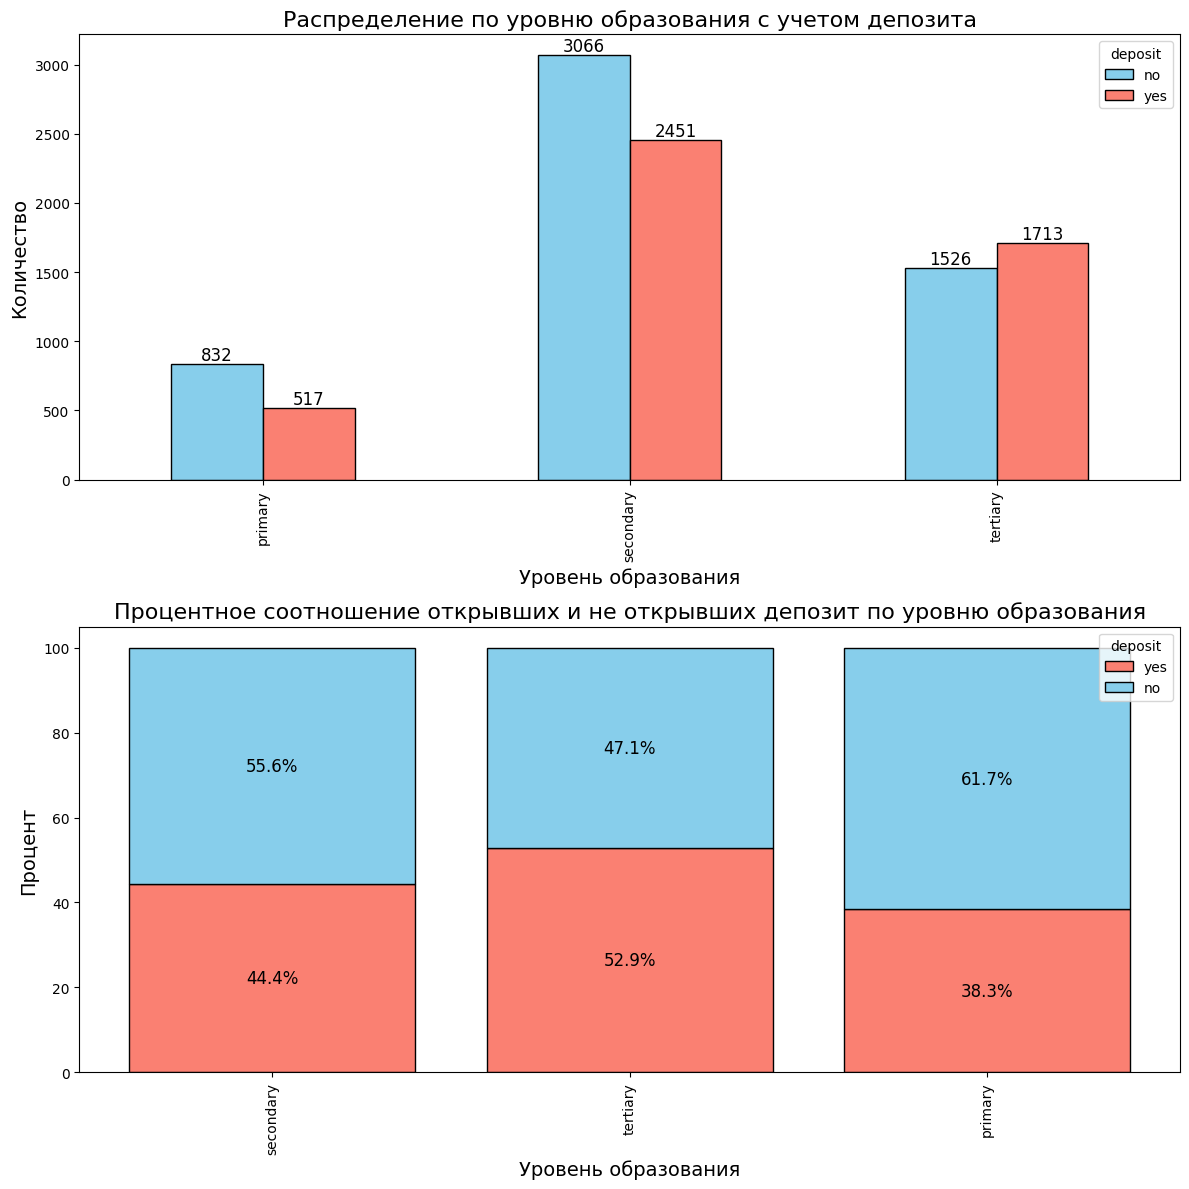

In [67]:


# Создание сводной таблицы для первого графика
pivot_table = df.pivot_table(index='education', columns='deposit', aggfunc='size', fill_value=0)

# Подсчет общего количества людей для каждой категории education
total_counts = df['education'].value_counts()

# Подсчет количества людей с открытым депозитом для каждой категории education
deposit_counts = df[df['deposit'] == 'yes']['education'].value_counts()

# Подсчет количества людей без депозита для каждой категории education
no_deposit_counts = df[df['deposit'] == 'no']['education'].value_counts()

# Вычисление процентного соотношения
percentage_deposit = (deposit_counts / total_counts) * 100
percentage_no_deposit = 100 - percentage_deposit

# Преобразование в DataFrame для удобства
percentage_deposit_df = percentage_deposit.reset_index()
percentage_deposit_df.columns = ['education', 'percentage_deposit']

percentage_no_deposit_df = percentage_no_deposit.reset_index()
percentage_no_deposit_df.columns = ['education', 'percentage_no_deposit']

# Объединение данных для построения стека
combined_df = pd.merge(percentage_deposit_df, percentage_no_deposit_df, on='education')

# Создание графиков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Первый график - количество людей по категориям education с разделением по депозиту
pivot_table.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_title('Распределение по уровню образования с учетом депозита', fontsize=16)
axes[0].set_xlabel('Уровень образования', fontsize=14)
axes[0].set_ylabel('Количество', fontsize=14)
axes[0].legend(title='deposit')
axes[0].tick_params(axis='x', rotation=90)
for container in axes[0].containers:
    axes[0].bar_label(container, label_type='edge', fontsize=12)

# Второй график - процентное соотношение открывших и не открывших депозит по категориям education
axes[1].bar(combined_df['education'], combined_df['percentage_deposit'], color='salmon', edgecolor='black', label='yes')
axes[1].bar(combined_df['education'], combined_df['percentage_no_deposit'], bottom=combined_df['percentage_deposit'], color='skyblue', edgecolor='black', label='no')
axes[1].set_title('Процентное соотношение открывших и не открывших депозит по уровню образования', fontsize=16)
axes[1].set_xlabel('Уровень образования', fontsize=14)
axes[1].set_ylabel('Процент', fontsize=14)
axes[1].legend(title='deposit')
axes[1].tick_params(axis='x', rotation=90)
for i in range(len(combined_df)):
    axes[1].text(i, combined_df['percentage_deposit'][i] / 2, f'{combined_df["percentage_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)
    axes[1].text(i, combined_df['percentage_deposit'][i] + combined_df['percentage_no_deposit'][i] / 2, f'{combined_df["percentage_no_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)

# Показать графики
plt.tight_layout()
plt.show()



education - следующий признак 

Имя | Процент | MCH
|--|--|--|
tertiary | 52.9% | C

Берем одну категорию, так как во всех остальных случаев приоблодает больше отказов, чем положителных депозитов


### default

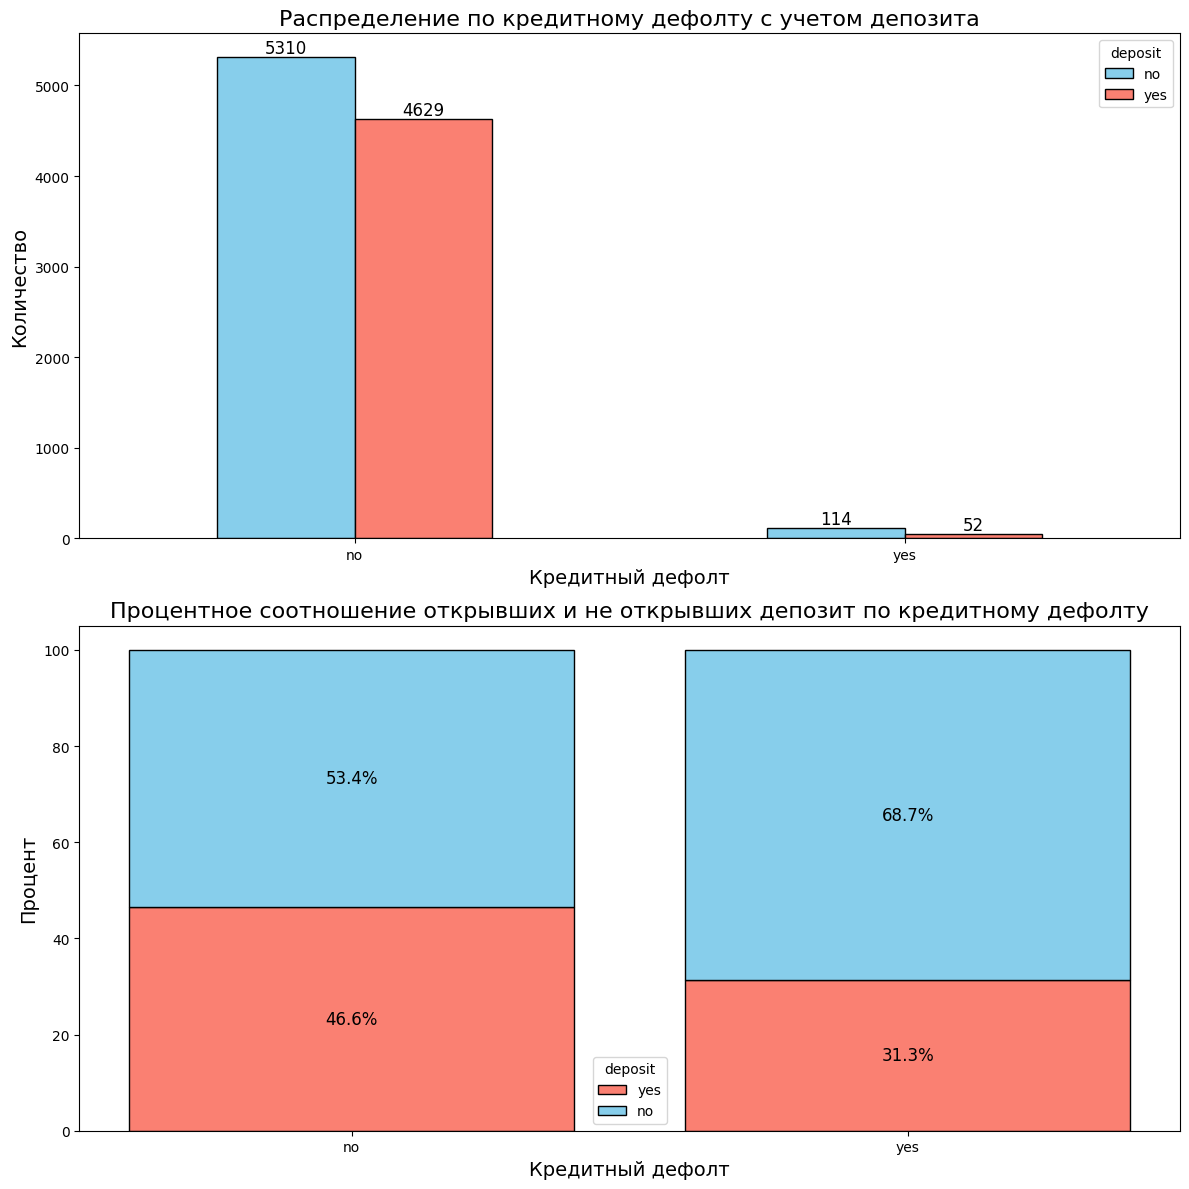

In [68]:


# Создание сводной таблицы для первого графика
pivot_table = df.pivot_table(index='default', columns='deposit', aggfunc='size', fill_value=0)

# Подсчет общего количества людей для каждой категории default
total_counts = df['default'].value_counts()

# Подсчет количества людей с открытым депозитом для каждой категории default
deposit_counts = df[df['deposit'] == 'yes']['default'].value_counts()

# Подсчет количества людей без депозита для каждой категории default
no_deposit_counts = df[df['deposit'] == 'no']['default'].value_counts()

# Вычисление процентного соотношения
percentage_deposit = (deposit_counts / total_counts) * 100
percentage_no_deposit = 100 - percentage_deposit

# Преобразование в DataFrame для удобства
percentage_deposit_df = percentage_deposit.reset_index()
percentage_deposit_df.columns = ['default', 'percentage_deposit']

percentage_no_deposit_df = percentage_no_deposit.reset_index()
percentage_no_deposit_df.columns = ['default', 'percentage_no_deposit']

# Объединение данных для построения стека
combined_df = pd.merge(percentage_deposit_df, percentage_no_deposit_df, on='default')

# Создание графиков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Первый график - количество людей по категориям default с разделением по депозиту
pivot_table.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_title('Распределение по кредитному дефолту с учетом депозита', fontsize=16)
axes[0].set_xlabel('Кредитный дефолт', fontsize=14)
axes[0].set_ylabel('Количество', fontsize=14)
axes[0].legend(title='deposit')
axes[0].tick_params(axis='x', rotation=0)
for container in axes[0].containers:
    axes[0].bar_label(container, label_type='edge', fontsize=12)

# Второй график - процентное соотношение открывших и не открывших депозит по категориям default
axes[1].bar(combined_df['default'], combined_df['percentage_deposit'], color='salmon', edgecolor='black', label='yes')
axes[1].bar(combined_df['default'], combined_df['percentage_no_deposit'], bottom=combined_df['percentage_deposit'], color='skyblue', edgecolor='black', label='no')
axes[1].set_title('Процентное соотношение открывших и не открывших депозит по кредитному дефолту', fontsize=16)
axes[1].set_xlabel('Кредитный дефолт', fontsize=14)
axes[1].set_ylabel('Процент', fontsize=14)
axes[1].legend(title='deposit')
axes[1].tick_params(axis='x', rotation=0)
for i in range(len(combined_df)):
    axes[1].text(i, combined_df['percentage_deposit'][i] / 2, f'{combined_df["percentage_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)
    axes[1].text(i, combined_df['percentage_deposit'][i] + combined_df['percentage_no_deposit'][i] / 2, f'{combined_df["percentage_no_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)

# Показать графики
plt.tight_layout()
plt.show()



default - следующий признак 

Имя | Процент | MCH
|--|--|--|
no | 46.6% | M

Берем одну категорию, так как во всех остальных случаев приоблодает больше отказов, чем положителных депозитов


### housing

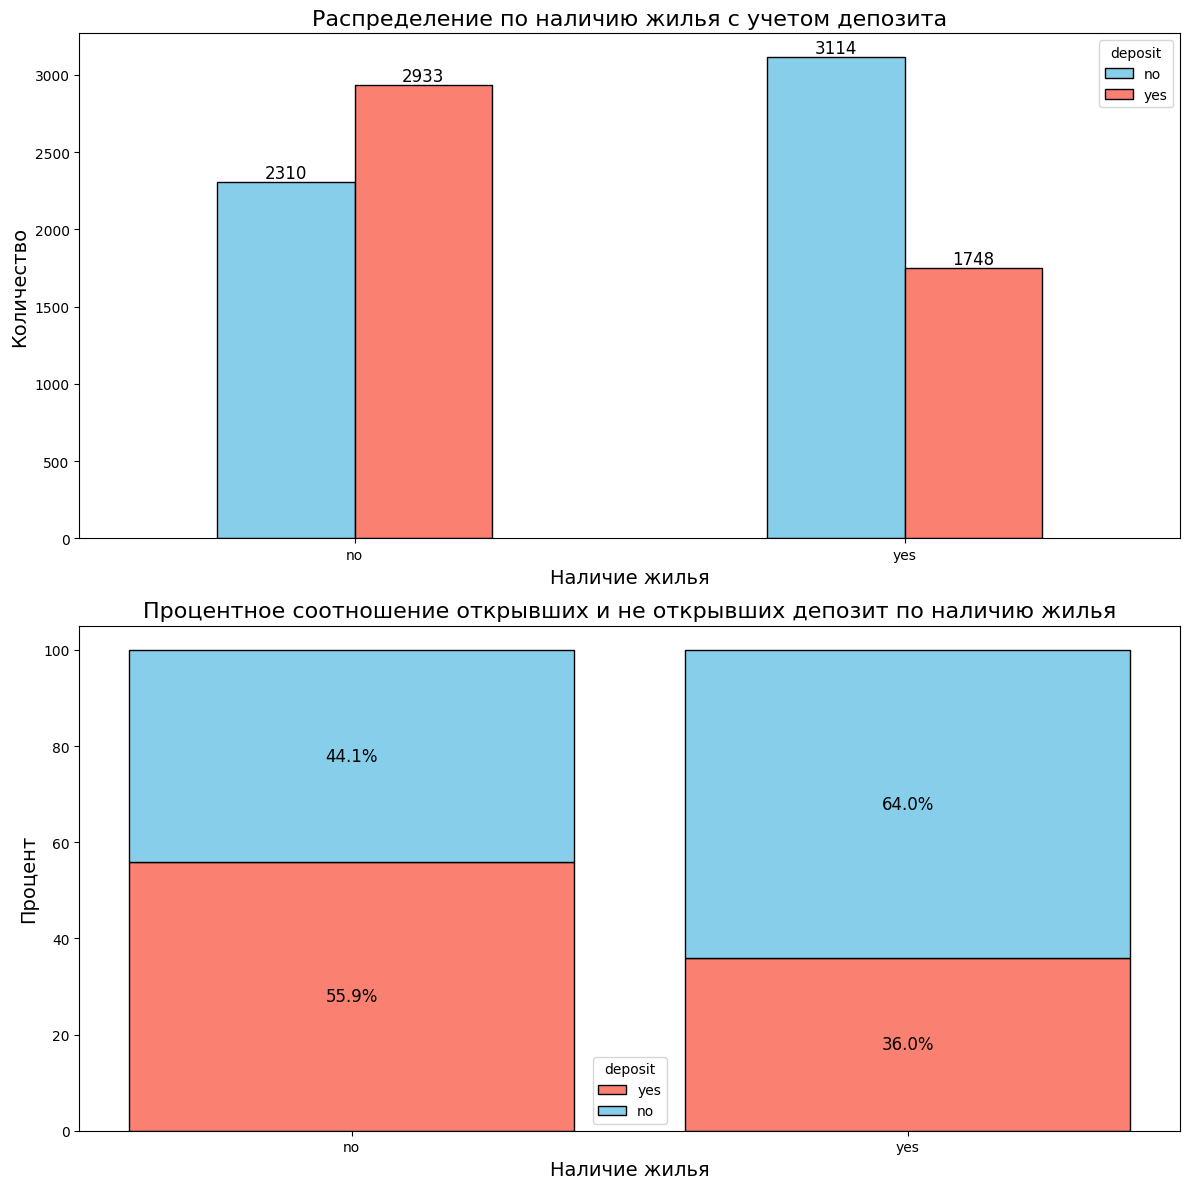

In [69]:


# Создание сводной таблицы для первого графика
pivot_table = df.pivot_table(index='housing', columns='deposit', aggfunc='size', fill_value=0)

# Подсчет общего количества людей для каждой категории housing
total_counts = df['housing'].value_counts()

# Подсчет количества людей с открытым депозитом для каждой категории housing
deposit_counts = df[df['deposit'] == 'yes']['housing'].value_counts()

# Подсчет количества людей без депозита для каждой категории housing
no_deposit_counts = df[df['deposit'] == 'no']['housing'].value_counts()

# Вычисление процентного соотношения
percentage_deposit = (deposit_counts / total_counts) * 100
percentage_no_deposit = 100 - percentage_deposit

# Преобразование в DataFrame для удобства
percentage_deposit_df = percentage_deposit.reset_index()
percentage_deposit_df.columns = ['housing', 'percentage_deposit']

percentage_no_deposit_df = percentage_no_deposit.reset_index()
percentage_no_deposit_df.columns = ['housing', 'percentage_no_deposit']

# Объединение данных для построения стека
combined_df = pd.merge(percentage_deposit_df, percentage_no_deposit_df, on='housing')

# Создание графиков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Первый график - количество людей по категориям housing с разделением по депозиту
pivot_table.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_title('Распределение по наличию жилья с учетом депозита', fontsize=16)
axes[0].set_xlabel('Наличие жилья', fontsize=14)
axes[0].set_ylabel('Количество', fontsize=14)
axes[0].legend(title='deposit')
axes[0].tick_params(axis='x', rotation=0)
for container in axes[0].containers:
    axes[0].bar_label(container, label_type='edge', fontsize=12)

# Второй график - процентное соотношение открывших и не открывших депозит по категориям housing
axes[1].bar(combined_df['housing'], combined_df['percentage_deposit'], color='salmon', edgecolor='black', label='yes')
axes[1].bar(combined_df['housing'], combined_df['percentage_no_deposit'], bottom=combined_df['percentage_deposit'], color='skyblue', edgecolor='black', label='no')
axes[1].set_title('Процентное соотношение открывших и не открывших депозит по наличию жилья', fontsize=16)
axes[1].set_xlabel('Наличие жилья', fontsize=14)
axes[1].set_ylabel('Процент', fontsize=14)
axes[1].legend(title='deposit')
axes[1].tick_params(axis='x', rotation=0)
for i in range(len(combined_df)):
    axes[1].text(i, combined_df['percentage_deposit'][i] / 2, f'{combined_df["percentage_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)
    axes[1].text(i, combined_df['percentage_deposit'][i] + combined_df['percentage_no_deposit'][i] / 2, f'{combined_df["percentage_no_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)

# Показать графики
plt.tight_layout()
plt.show()



housing - следующий признак 

Имя | Процент | MCH
|--|--|--|
no | 53.9% | C

Берем одну категорию, так как во всех остальных случаев приоблодает больше отказов, чем положителных депозитов


### loan

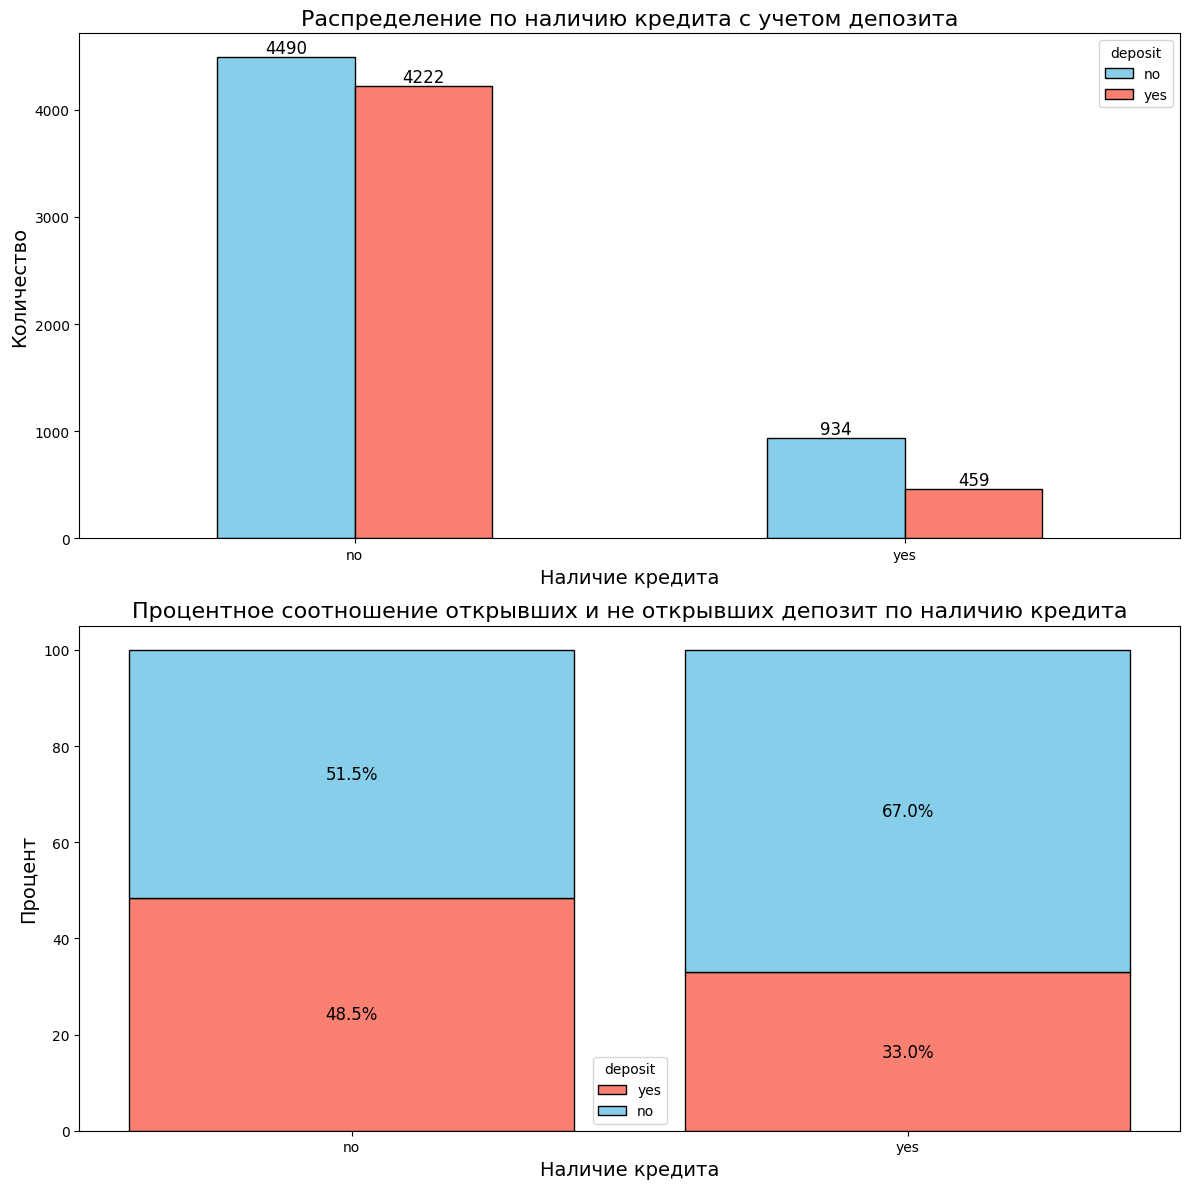

In [70]:


# Создание сводной таблицы для первого графика
pivot_table = df.pivot_table(index='loan', columns='deposit', aggfunc='size', fill_value=0)

# Подсчет общего количества людей для каждой категории loan
total_counts = df['loan'].value_counts()

# Подсчет количества людей с открытым депозитом для каждой категории loan
deposit_counts = df[df['deposit'] == 'yes']['loan'].value_counts()

# Подсчет количества людей без депозита для каждой категории loan
no_deposit_counts = df[df['deposit'] == 'no']['loan'].value_counts()

# Вычисление процентного соотношения
percentage_deposit = (deposit_counts / total_counts) * 100
percentage_no_deposit = 100 - percentage_deposit

# Преобразование в DataFrame для удобства
percentage_deposit_df = percentage_deposit.reset_index()
percentage_deposit_df.columns = ['loan', 'percentage_deposit']

percentage_no_deposit_df = percentage_no_deposit.reset_index()
percentage_no_deposit_df.columns = ['loan', 'percentage_no_deposit']

# Объединение данных для построения стека
combined_df = pd.merge(percentage_deposit_df, percentage_no_deposit_df, on='loan')

# Создание графиков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Первый график - количество людей по категориям loan с разделением по депозиту
pivot_table.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_title('Распределение по наличию кредита с учетом депозита', fontsize=16)
axes[0].set_xlabel('Наличие кредита', fontsize=14)
axes[0].set_ylabel('Количество', fontsize=14)
axes[0].legend(title='deposit')
axes[0].tick_params(axis='x', rotation=0)
for container in axes[0].containers:
    axes[0].bar_label(container, label_type='edge', fontsize=12)

# Второй график - процентное соотношение открывших и не открывших депозит по категориям loan
axes[1].bar(combined_df['loan'], combined_df['percentage_deposit'], color='salmon', edgecolor='black', label='yes')
axes[1].bar(combined_df['loan'], combined_df['percentage_no_deposit'], bottom=combined_df['percentage_deposit'], color='skyblue', edgecolor='black', label='no')
axes[1].set_title('Процентное соотношение открывших и не открывших депозит по наличию кредита', fontsize=16)
axes[1].set_xlabel('Наличие кредита', fontsize=14)
axes[1].set_ylabel('Процент', fontsize=14)
axes[1].legend(title='deposit')
axes[1].tick_params(axis='x', rotation=0)
for i in range(len(combined_df)):
    axes[1].text(i, combined_df['percentage_deposit'][i] / 2, f'{combined_df["percentage_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)
    axes[1].text(i, combined_df['percentage_deposit'][i] + combined_df['percentage_no_deposit'][i] / 2, f'{combined_df["percentage_no_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)

# Показать графики
plt.tight_layout()
plt.show()



loan - следующий признак 

Имя | Процент | MCH
|--|--|--|
no | 48.5% | M

Берем одну категорию, так как во всех остальных случаев приоблодает больше отказов, чем положителных депозитов


### contact

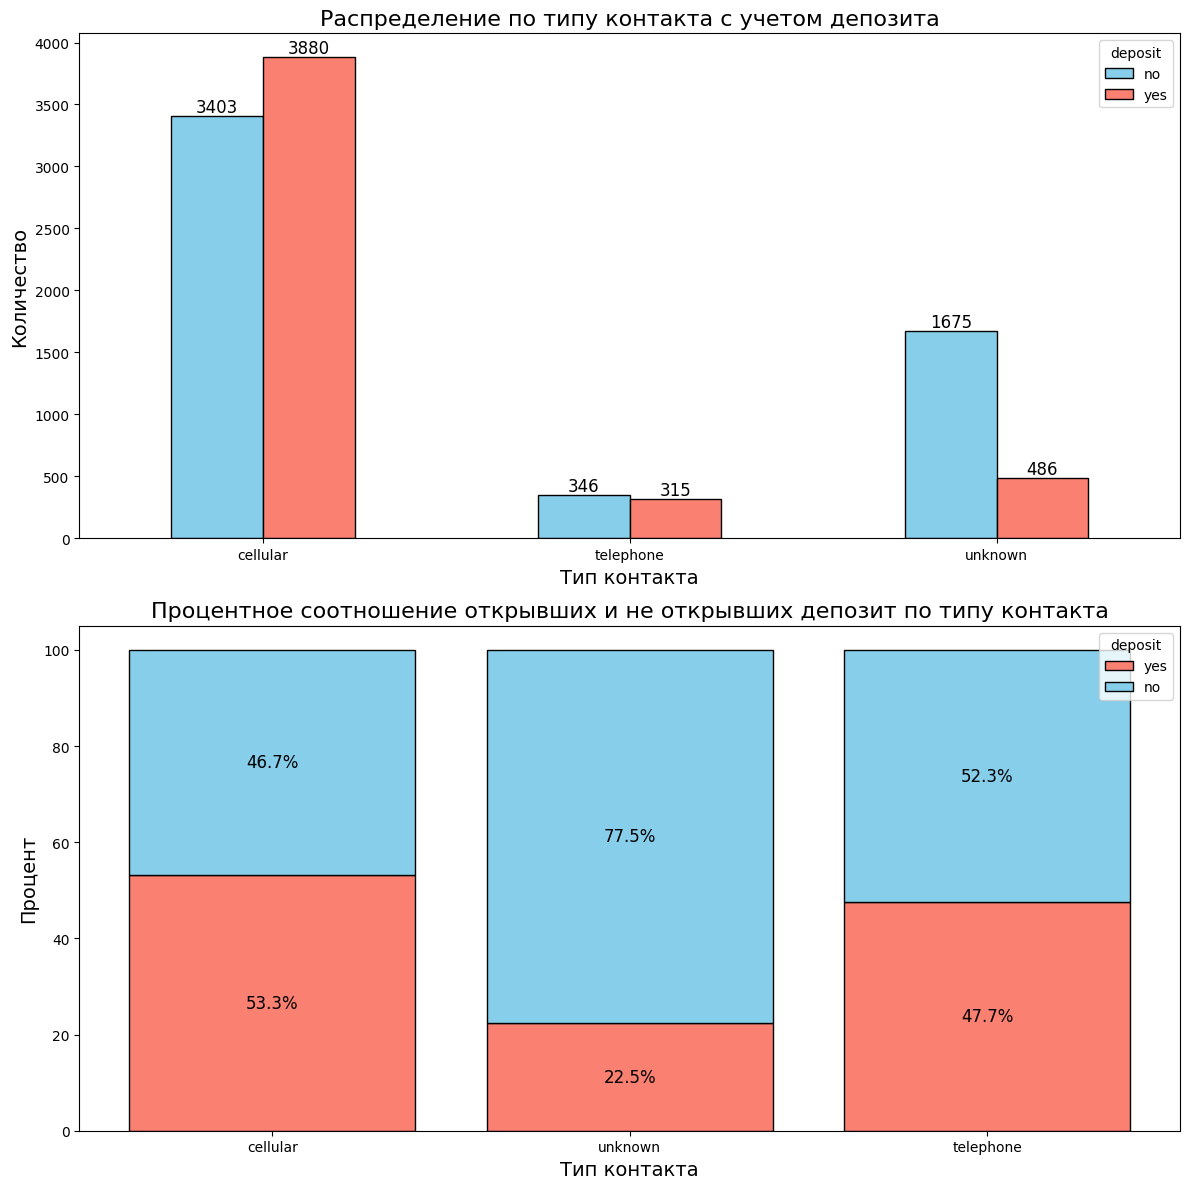

In [71]:


# Создание сводной таблицы для первого графика
pivot_table = df.pivot_table(index='contact', columns='deposit', aggfunc='size', fill_value=0)

# Подсчет общего количества людей для каждого типа контакта
total_counts = df['contact'].value_counts()

# Подсчет количества людей с открытым депозитом для каждого типа контакта
deposit_counts = df[df['deposit'] == 'yes']['contact'].value_counts()

# Подсчет количества людей без депозита для каждого типа контакта
no_deposit_counts = df[df['deposit'] == 'no']['contact'].value_counts()

# Вычисление процентного соотношения
percentage_deposit = (deposit_counts / total_counts) * 100
percentage_no_deposit = 100 - percentage_deposit

# Преобразование в DataFrame для удобства
percentage_deposit_df = percentage_deposit.reset_index()
percentage_deposit_df.columns = ['contact', 'percentage_deposit']

percentage_no_deposit_df = percentage_no_deposit.reset_index()
percentage_no_deposit_df.columns = ['contact', 'percentage_no_deposit']

# Объединение данных для построения стека
combined_df = pd.merge(percentage_deposit_df, percentage_no_deposit_df, on='contact')

# Создание графиков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Первый график - количество людей по типу контакта с разделением по депозиту
pivot_table.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_title('Распределение по типу контакта с учетом депозита', fontsize=16)
axes[0].set_xlabel('Тип контакта', fontsize=14)
axes[0].set_ylabel('Количество', fontsize=14)
axes[0].legend(title='deposit')
axes[0].tick_params(axis='x', rotation=0)
for container in axes[0].containers:
    axes[0].bar_label(container, label_type='edge', fontsize=12)

# Второй график - процентное соотношение открывших и не открывших депозит по типу контакта
axes[1].bar(combined_df['contact'], combined_df['percentage_deposit'], color='salmon', edgecolor='black', label='yes')
axes[1].bar(combined_df['contact'], combined_df['percentage_no_deposit'], bottom=combined_df['percentage_deposit'], color='skyblue', edgecolor='black', label='no')
axes[1].set_title('Процентное соотношение открывших и не открывших депозит по типу контакта', fontsize=16)
axes[1].set_xlabel('Тип контакта', fontsize=14)
axes[1].set_ylabel('Процент', fontsize=14)
axes[1].legend(title='deposit')
axes[1].tick_params(axis='x', rotation=0)
for i in range(len(combined_df)):
    axes[1].text(i, combined_df['percentage_deposit'][i] / 2, f'{combined_df["percentage_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)
    axes[1].text(i, combined_df['percentage_deposit'][i] + combined_df['percentage_no_deposit'][i] / 2, f'{combined_df["percentage_no_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)

# Показать графики
plt.tight_layout()
plt.show()



contact - следующий признак 

Имя | Процент | MCH
|--|--|--|
cellular | 53.3% | M

Берем одну категорию, так как во всех остальных случаев приоблодает больше отказов, чем положителных депозитов


### month

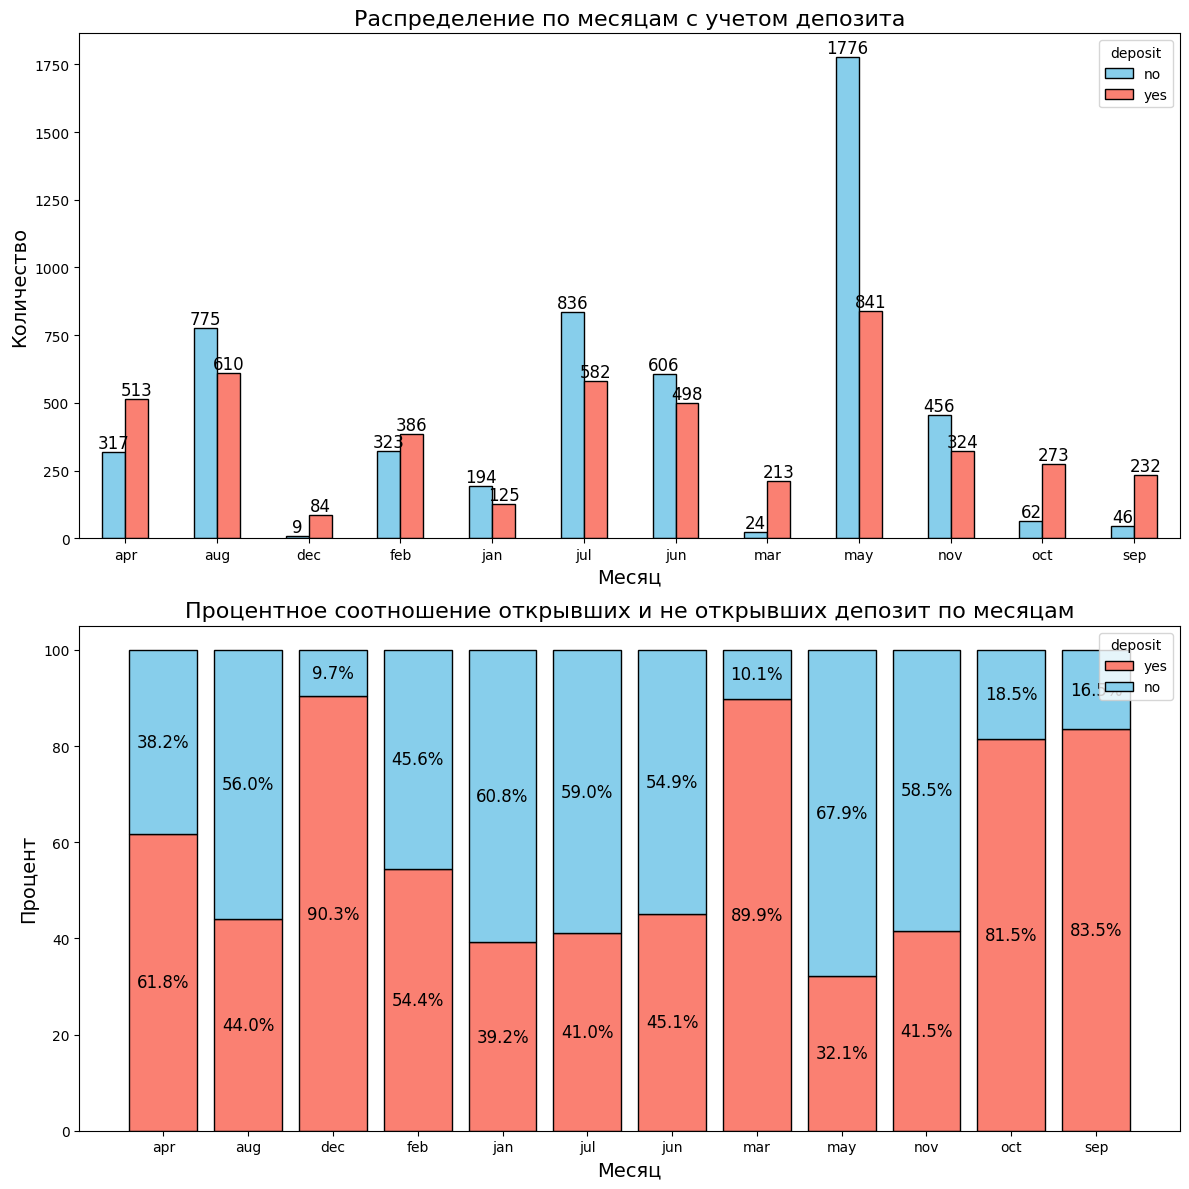

In [72]:


# Создание сводной таблицы для первого графика
pivot_table = df.pivot_table(index='month', columns='deposit', aggfunc='size', fill_value=0)

# Подсчет общего количества людей для каждого месяца
total_counts = df['month'].value_counts()

# Подсчет количества людей с открытым депозитом для каждого месяца
deposit_counts = df[df['deposit'] == 'yes']['month'].value_counts()

# Подсчет количества людей без депозита для каждого месяца
no_deposit_counts = df[df['deposit'] == 'no']['month'].value_counts()

# Вычисление процентного соотношения
percentage_deposit = (deposit_counts / total_counts) * 100
percentage_no_deposit = 100 - percentage_deposit

# Преобразование в DataFrame для удобства
percentage_deposit_df = percentage_deposit.reset_index()
percentage_deposit_df.columns = ['month', 'percentage_deposit']

percentage_no_deposit_df = percentage_no_deposit.reset_index()
percentage_no_deposit_df.columns = ['month', 'percentage_no_deposit']

# Объединение данных для построения стека
combined_df = pd.merge(percentage_deposit_df, percentage_no_deposit_df, on='month')

# Создание графиков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Первый график - количество людей по месяцам с разделением по депозиту
pivot_table.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_title('Распределение по месяцам с учетом депозита', fontsize=16)
axes[0].set_xlabel('Месяц', fontsize=14)
axes[0].set_ylabel('Количество', fontsize=14)
axes[0].legend(title='deposit')
axes[0].tick_params(axis='x', rotation=0)
for container in axes[0].containers:
    axes[0].bar_label(container, label_type='edge', fontsize=12)

# Второй график - процентное соотношение открывших и не открывших депозит по месяцам
axes[1].bar(combined_df['month'], combined_df['percentage_deposit'], color='salmon', edgecolor='black', label='yes')
axes[1].bar(combined_df['month'], combined_df['percentage_no_deposit'], bottom=combined_df['percentage_deposit'], color='skyblue', edgecolor='black', label='no')
axes[1].set_title('Процентное соотношение открывших и не открывших депозит по месяцам', fontsize=16)
axes[1].set_xlabel('Месяц', fontsize=14)
axes[1].set_ylabel('Процент', fontsize=14)
axes[1].legend(title='deposit')
axes[1].tick_params(axis='x', rotation=0)
for i in range(len(combined_df)):
    axes[1].text(i, combined_df['percentage_deposit'][i] / 2, f'{combined_df["percentage_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)
    axes[1].text(i, combined_df['percentage_deposit'][i] + combined_df['percentage_no_deposit'][i] / 2, f'{combined_df["percentage_no_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)

# Показать графики
plt.tight_layout()
plt.show()



month - следующий признак 

Имя | Процент | MCH
|--|--|--|
dec | 90.3% | H
mar | 89.9% | H
oct | 81.5% | H
sep | 83.5% | H
apr | 61.8% | C
feb | 54.4% | H

Берем шесть категорий, так как во всех остальных случаев приоблодает больше отказов, чем положителных депозитов


### poutcome

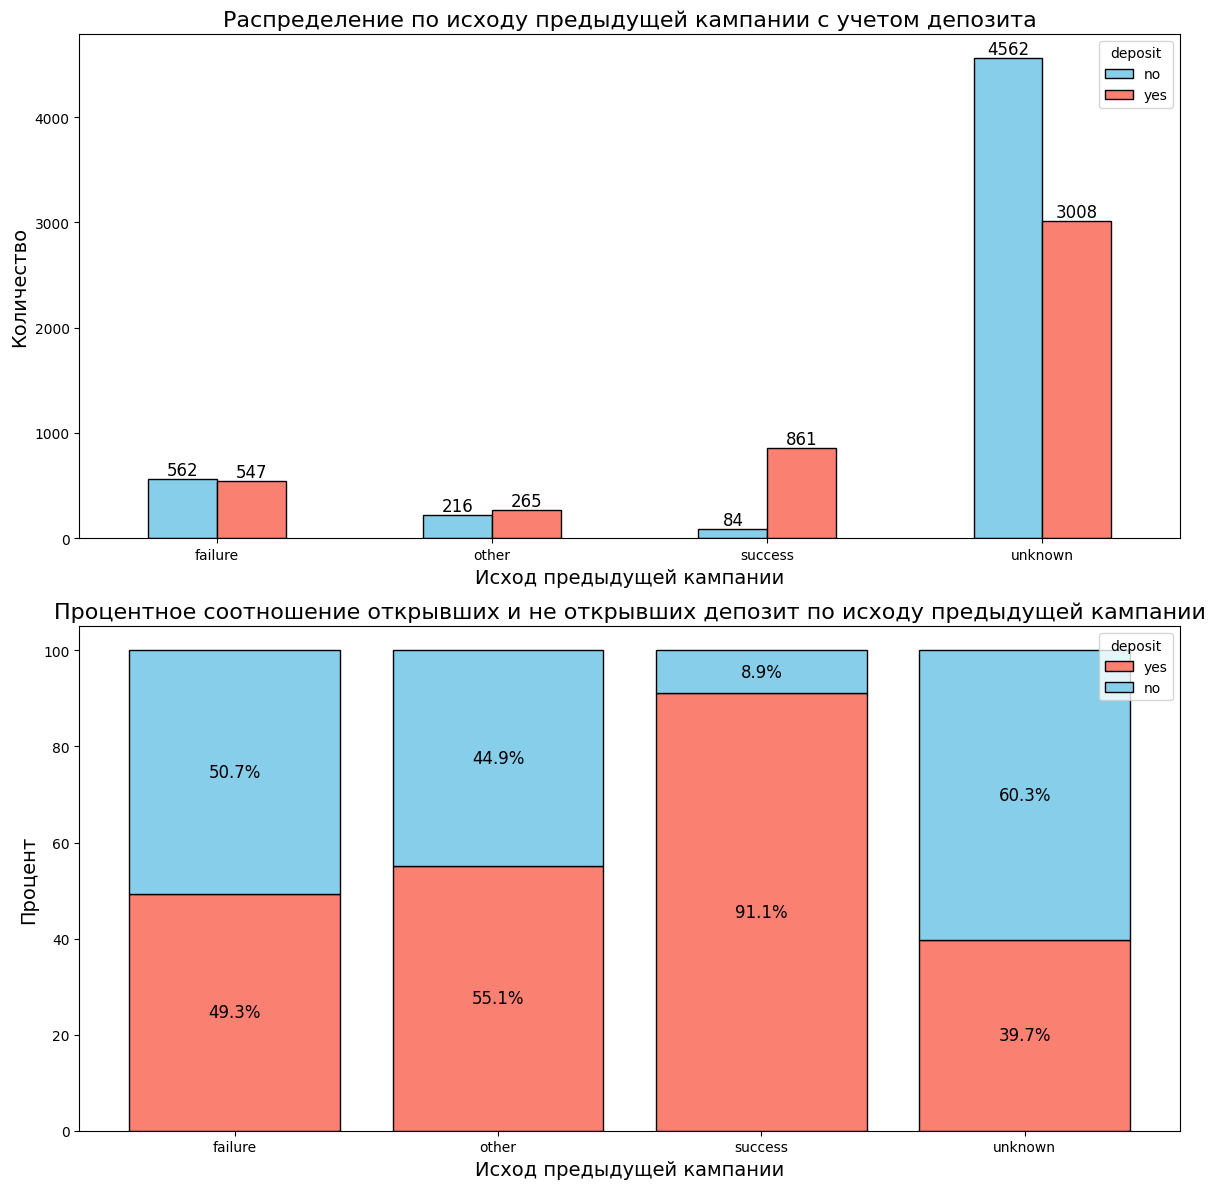

In [73]:


# Создание сводной таблицы для первого графика
pivot_table = df.pivot_table(index='poutcome', columns='deposit', aggfunc='size', fill_value=0)

# Подсчет общего количества людей для каждого варианта poutcome
total_counts = df['poutcome'].value_counts()

# Подсчет количества людей с открытым депозитом для каждого варианта poutcome
deposit_counts = df[df['deposit'] == 'yes']['poutcome'].value_counts()

# Подсчет количества людей без депозита для каждого варианта poutcome
no_deposit_counts = df[df['deposit'] == 'no']['poutcome'].value_counts()

# Вычисление процентного соотношения
percentage_deposit = (deposit_counts / total_counts) * 100
percentage_no_deposit = 100 - percentage_deposit

# Преобразование в DataFrame для удобства
percentage_deposit_df = percentage_deposit.reset_index()
percentage_deposit_df.columns = ['poutcome', 'percentage_deposit']

percentage_no_deposit_df = percentage_no_deposit.reset_index()
percentage_no_deposit_df.columns = ['poutcome', 'percentage_no_deposit']

# Объединение данных для построения стека
combined_df = pd.merge(percentage_deposit_df, percentage_no_deposit_df, on='poutcome')

# Создание графиков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Первый график - количество людей по вариантам poutcome с разделением по депозиту
pivot_table.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_title('Распределение по исходу предыдущей кампании с учетом депозита', fontsize=16)
axes[0].set_xlabel('Исход предыдущей кампании', fontsize=14)
axes[0].set_ylabel('Количество', fontsize=14)
axes[0].legend(title='deposit')
axes[0].tick_params(axis='x', rotation=0)
for container in axes[0].containers:
    axes[0].bar_label(container, label_type='edge', fontsize=12)

# Второй график - процентное соотношение открывших и не открывших депозит по вариантам poutcome
axes[1].bar(combined_df['poutcome'], combined_df['percentage_deposit'], color='salmon', edgecolor='black', label='yes')
axes[1].bar(combined_df['poutcome'], combined_df['percentage_no_deposit'], bottom=combined_df['percentage_deposit'], color='skyblue', edgecolor='black', label='no')
axes[1].set_title('Процентное соотношение открывших и не открывших депозит по исходу предыдущей кампании', fontsize=16)
axes[1].set_xlabel('Исход предыдущей кампании', fontsize=14)
axes[1].set_ylabel('Процент', fontsize=14)
axes[1].legend(title='deposit')
axes[1].tick_params(axis='x', rotation=0)
for i in range(len(combined_df)):
    axes[1].text(i, combined_df['percentage_deposit'][i] / 2, f'{combined_df["percentage_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)
    axes[1].text(i, combined_df['percentage_deposit'][i] + combined_df['percentage_no_deposit'][i] / 2, f'{combined_df["percentage_no_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)

# Показать графики
plt.tight_layout()
plt.show()



poutcome - следующий признак 

Имя | Процент | MCH
|--|--|--|
success | 91.1% | H
mar | 55.1% | H
failure | 49.3% | H


Берем три категории, так как во всех остальных случаев приоблодает больше отказов, чем положителных депозитов


### age_category

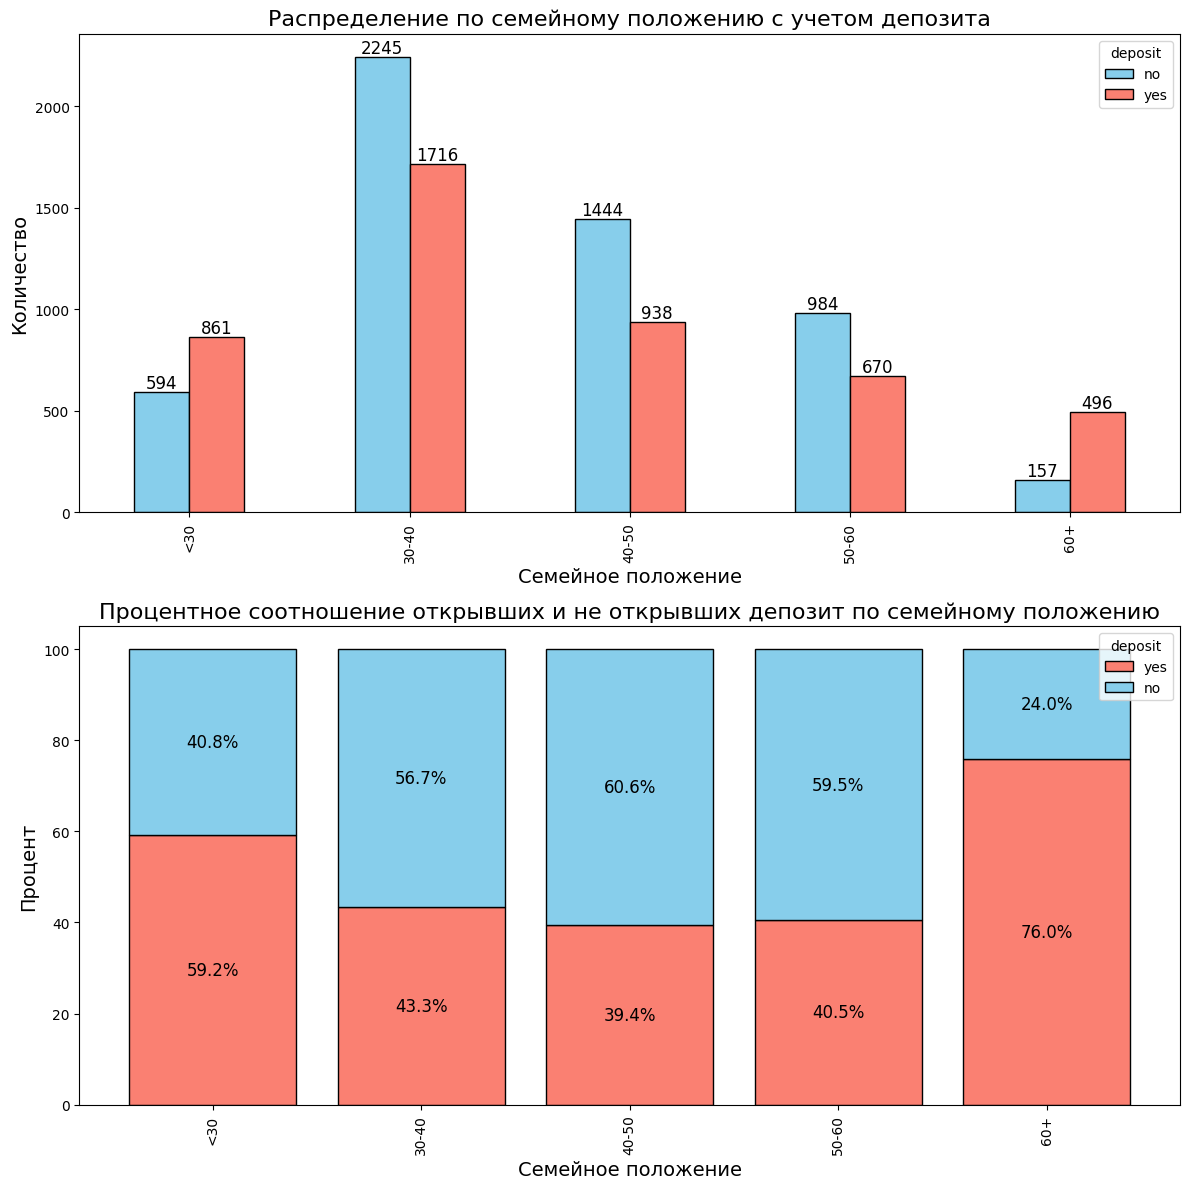

In [74]:


# Создание сводной таблицы для первого графика
pivot_table = df.pivot_table(index='age_category', columns='deposit', aggfunc='size', fill_value=0)

# Подсчет общего количества людей для каждой категории marital
total_counts = df['age_category'].value_counts()

# Подсчет количества людей с открытым депозитом для каждой категории marital
deposit_counts = df[df['deposit'] == 'yes']['age_category'].value_counts()

# Подсчет количества людей без депозита для каждой категории marital
no_deposit_counts = df[df['deposit'] == 'no']['age_category'].value_counts()

# Вычисление процентного соотношения
percentage_deposit = (deposit_counts / total_counts) * 100
percentage_no_deposit = 100 - percentage_deposit

# Преобразование в DataFrame для удобства
percentage_deposit_df = percentage_deposit.reset_index()
percentage_deposit_df.columns = ['age_category', 'percentage_deposit']

percentage_no_deposit_df = percentage_no_deposit.reset_index()
percentage_no_deposit_df.columns = ['age_category', 'percentage_no_deposit']

# Объединение данных для построения стека
combined_df = pd.merge(percentage_deposit_df, percentage_no_deposit_df, on='age_category')

# Создание графиков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Первый график - количество людей по категориям marital с разделением по депозиту
pivot_table.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_title('Распределение по семейному положению с учетом депозита', fontsize=16)
axes[0].set_xlabel('Семейное положение', fontsize=14)
axes[0].set_ylabel('Количество', fontsize=14)
axes[0].legend(title='deposit')
axes[0].tick_params(axis='x', rotation=90)
for container in axes[0].containers:
    axes[0].bar_label(container, label_type='edge', fontsize=12)

# Второй график - процентное соотношение открывших и не открывших депозит по категориям marital
axes[1].bar(combined_df['age_category'], combined_df['percentage_deposit'], color='salmon', edgecolor='black', label='yes')
axes[1].bar(combined_df['age_category'], combined_df['percentage_no_deposit'], bottom=combined_df['percentage_deposit'], color='skyblue', edgecolor='black', label='no')
axes[1].set_title('Процентное соотношение открывших и не открывших депозит по семейному положению', fontsize=16)
axes[1].set_xlabel('Семейное положение', fontsize=14)
axes[1].set_ylabel('Процент', fontsize=14)
axes[1].legend(title='deposit')
axes[1].tick_params(axis='x', rotation=90)
for i in range(len(combined_df)):
    axes[1].text(i, combined_df['percentage_deposit'][i] / 2, f'{combined_df["percentage_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)
    axes[1].text(i, combined_df['percentage_deposit'][i] + combined_df['percentage_no_deposit'][i] / 2, f'{combined_df["percentage_no_deposit"][i]:.1f}%', ha='center', va='center', fontsize=12)

# Показать графики
plt.tight_layout()
plt.show()



age_category - следующий признак 

Имя | Процент | MCH
|--|--|--|
60+ | 76.0% | H
<30 | 59.2% | c



Берем две категории, так как во всех остальных случаев приоблодает больше отказов, чем положителных депозитов


### day

In [75]:
df['day'].describe()

count    10105.000000
mean        15.590302
std          8.441510
min          1.000000
25%          8.000000
50%         15.000000
75%         22.000000
max         31.000000
Name: day, dtype: float64

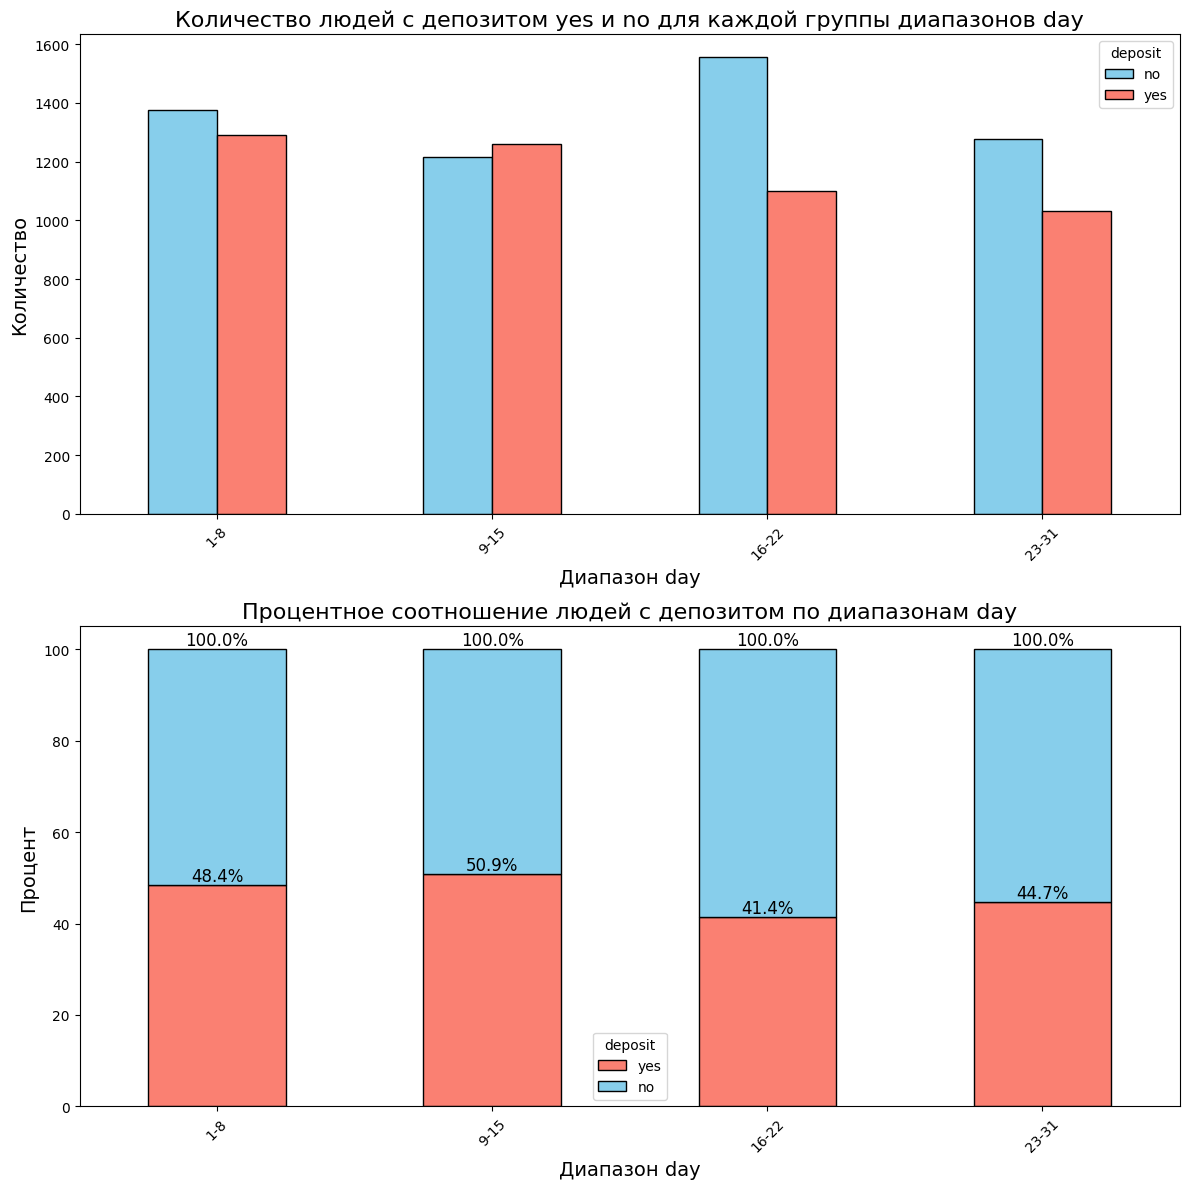

In [76]:

# # Разделение day на диапазоны, учитывая статистические данные
# day_bins = pd.cut(df['day'], bins=[0, 5, 10, 15, 20, 25, 30, 31], 
#                       labels=['<5', '5-10', '10-15', '15-20', '20-25', '25-30', '30+'])

# Разделение day на диапазоны, учитывая статистические данные
day_bins = pd.cut(df['day'], bins=[0, 8, 15, 22, 31], 
                  labels=['1-8', '9-15', '16-22', '23-31'])

# Группировка данных по 'day_bins' и 'deposit' для подсчета количества (count) в каждой категории
grouped_day_deposit = df.groupby([day_bins, 'deposit']).size().unstack(fill_value=0)

# Создание сводной таблицы для процентного соотношения по диапазонам day
day_deposit_counts = df.groupby([day_bins, 'deposit']).size().unstack(fill_value=0)
day_deposit_percentages = (day_deposit_counts.div(day_deposit_counts.sum(axis=1), axis=0) * 100).reset_index()

# Пересортировка столбцов, чтобы "yes" был первым
day_deposit_percentages = day_deposit_percentages[['day', 'yes', 'no']]

# Создание графиков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Верхний график - количество людей с депозитом yes и no для каждой группы диапазонов day
grouped_day_deposit.plot(kind='bar', stacked=False, ax=axes[0], color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_title('Количество людей с депозитом yes и no для каждой группы диапазонов day', fontsize=16)
axes[0].set_xlabel('Диапазон day', fontsize=14)
axes[0].set_ylabel('Количество', fontsize=14)
axes[0].legend(title='deposit', loc='upper right')
axes[0].tick_params(axis='x', rotation=45)

# Нижний график - процентное соотношение людей с депозитом для каждого диапазона day
day_deposit_percentages.plot(kind='bar', x='day', stacked=True, color=['salmon', 'skyblue'], edgecolor='black', ax=axes[1])
axes[1].set_title('Процентное соотношение людей с депозитом по диапазонам day', fontsize=16)
axes[1].set_xlabel('Диапазон day', fontsize=14)
axes[1].set_ylabel('Процент', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
for container in axes[1].containers:
    axes[1].bar_label(container, label_type='edge', fontsize=12, fmt='%.1f%%')

# Показать графики
plt.tight_layout()
plt.show()



day - следующий признак 

Имя | Процент | MCH
|--|--|--|
9-15 | 50.9% | C
1-8 | 48.4% | C



Берем две категории, так как во всех остальных случаев приоблодает больше отказов, чем положителных депозитов


### duration

In [77]:
df['duration'].describe()

count    10105.000000
mean       368.742603
std        346.651524
min          2.000000
25%        137.000000
50%        252.000000
75%        490.000000
max       3881.000000
Name: duration, dtype: float64

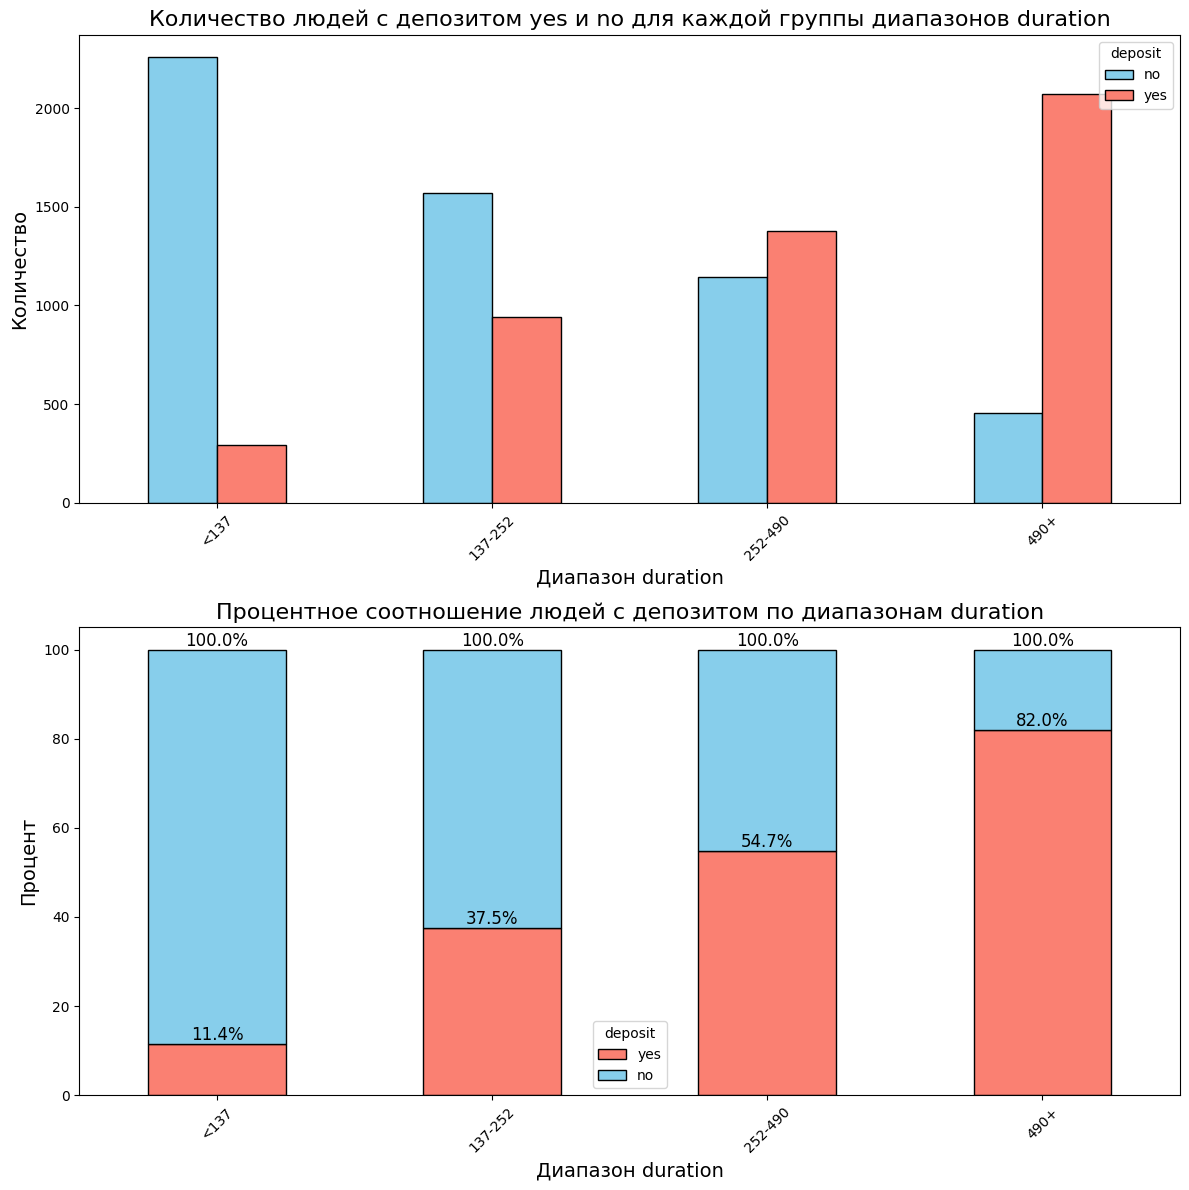

In [78]:


# # Разделение duration на диапазоны, учитывая статистические данные
# duration_bins = pd.cut(df['duration'], bins=[2, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000], 
#                       labels=['0-500', '500-1000', '1000-1500', '1500-2000', '2000-2500', '2500-3000', '3000-3500', '3500-4000'])

# Разделение duration на диапазоны, учитывая статистические данные
duration_bins = pd.cut(df['duration'], bins=[2, 137, 252, 490, 3881], 
                      labels=['<137', '137-252', '252-490', '490+'])

# Группировка данных по 'duration_bins' и 'deposit' для подсчета количества (count) в каждой категории
grouped_duration_deposit = df.groupby([duration_bins, 'deposit']).size().unstack(fill_value=0)

# Создание сводной таблицы для процентного соотношения по диапазонам duration
duration_deposit_counts = df.groupby([duration_bins, 'deposit']).size().unstack(fill_value=0)
duration_deposit_percentages = (duration_deposit_counts.div(duration_deposit_counts.sum(axis=1), axis=0) * 100).reset_index()

# Пересортировка столбцов, чтобы "yes" был первым
duration_deposit_percentages = duration_deposit_percentages[['duration', 'yes', 'no']]

# Создание графиков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Верхний график - количество людей с депозитом yes и no для каждой группы диапазонов duration
grouped_duration_deposit.plot(kind='bar', stacked=False, ax=axes[0], color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_title('Количество людей с депозитом yes и no для каждой группы диапазонов duration', fontsize=16)
axes[0].set_xlabel('Диапазон duration', fontsize=14)
axes[0].set_ylabel('Количество', fontsize=14)
axes[0].legend(title='deposit', loc='upper right')
axes[0].tick_params(axis='x', rotation=45)

# Нижний график - процентное соотношение людей с депозитом для каждого диапазона duration
duration_deposit_percentages.plot(kind='bar', x='duration', stacked=True, color=['salmon', 'skyblue'], edgecolor='black', ax=axes[1])
axes[1].set_title('Процентное соотношение людей с депозитом по диапазонам duration', fontsize=16)
axes[1].set_xlabel('Диапазон duration', fontsize=14)
axes[1].set_ylabel('Процент', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
for container in axes[1].containers:
    axes[1].bar_label(container, label_type='edge', fontsize=12, fmt='%.1f%%')

# Показать графики
plt.tight_layout()
plt.show()



duration - следующий признак 

Имя | Процент | MCH
|--|--|--|
490+ | 82.0% | C
252-490 | 54.7% | C



Берем две категории, так как во всех остальных случаев приоблодает больше отказов, чем положителных депозитов


### campaign

In [79]:
df['campaign'].describe()

count    10105.000000
mean         2.517170
std          2.707159
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         43.000000
Name: campaign, dtype: float64

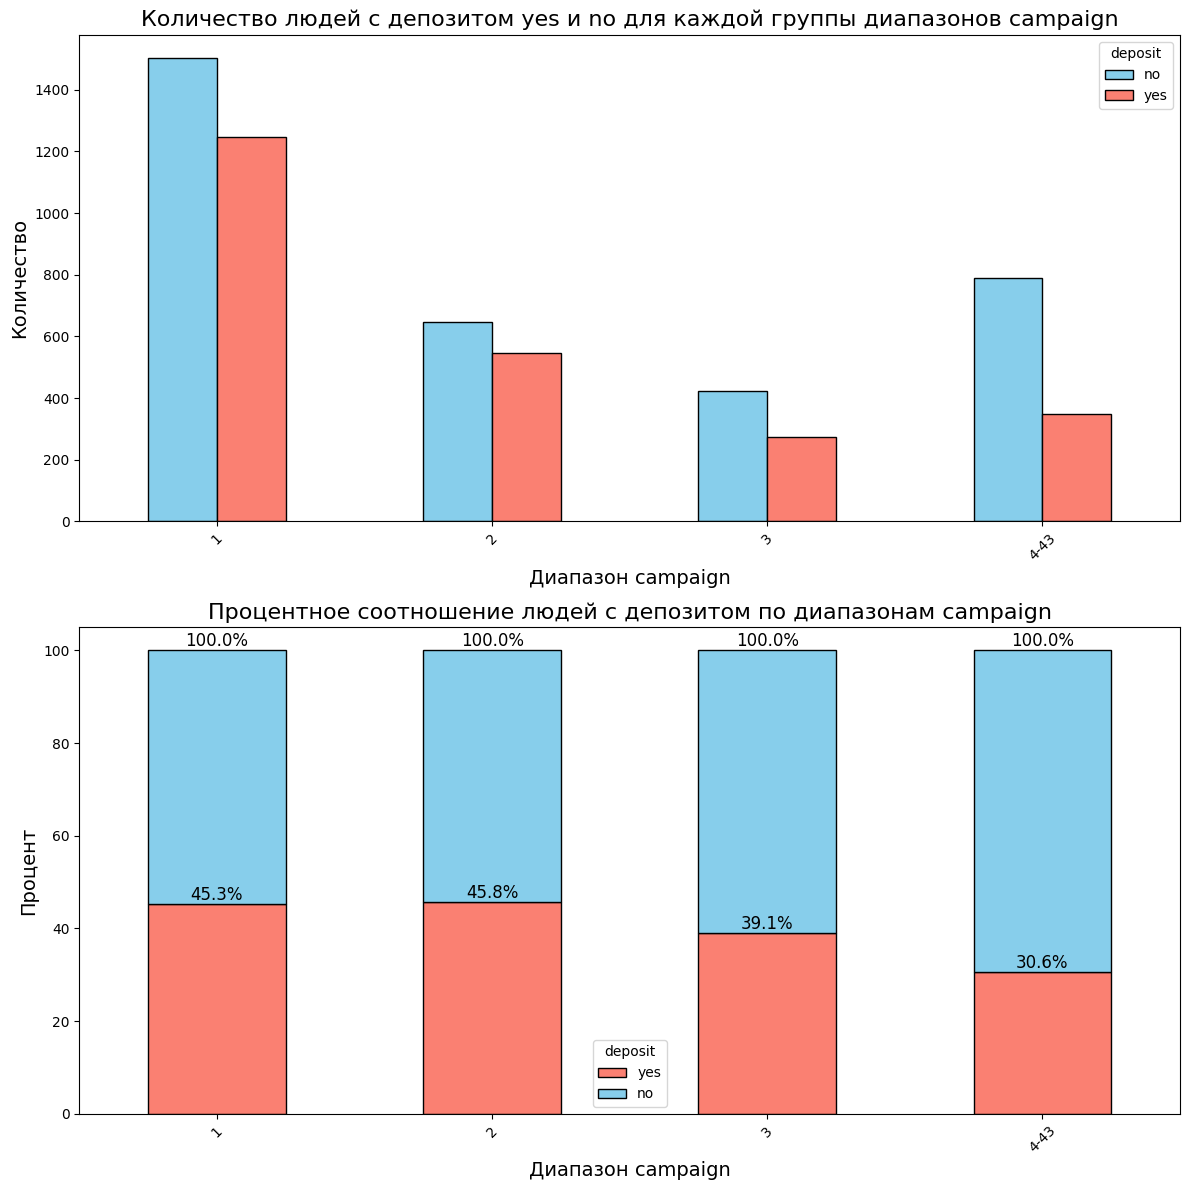

In [80]:


# Разделение campaign на диапазоны, учитывая статистические данные
campaign_bins = pd.cut(df['campaign'], bins=[1, 2, 3, 4, 43], 
                      labels=['1', '2', '3', '4-43'])

# # Разделение campaign на диапазоны
# campaign_bins = pd.cut(df['campaign'], bins=[0, 5, 10, 15, 20, 25, 30, 35, 43], 
#                        labels=['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-43'])
# Группировка данных по 'campaign_bins' и 'deposit' для подсчета количества (count) в каждой категории
grouped_campaign_deposit = df.groupby([campaign_bins, 'deposit']).size().unstack(fill_value=0)

# Создание сводной таблицы для процентного соотношения по диапазонам campaign
campaign_deposit_counts = df.groupby([campaign_bins, 'deposit']).size().unstack(fill_value=0)
campaign_deposit_percentages = (campaign_deposit_counts.div(campaign_deposit_counts.sum(axis=1), axis=0) * 100).reset_index()

# Пересортировка столбцов, чтобы "yes" был первым
campaign_deposit_percentages = campaign_deposit_percentages[['campaign', 'yes', 'no']]

# Создание графиков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Верхний график - количество людей с депозитом yes и no для каждой группы диапазонов campaign
grouped_campaign_deposit.plot(kind='bar', stacked=False, ax=axes[0], color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_title('Количество людей с депозитом yes и no для каждой группы диапазонов campaign', fontsize=16)
axes[0].set_xlabel('Диапазон campaign', fontsize=14)
axes[0].set_ylabel('Количество', fontsize=14)
axes[0].legend(title='deposit', loc='upper right')
axes[0].tick_params(axis='x', rotation=45)

# Нижний график - процентное соотношение людей с депозитом для каждого диапазона campaign
campaign_deposit_percentages.plot(kind='bar', x='campaign', stacked=True, color=['salmon', 'skyblue'], edgecolor='black', ax=axes[1])
axes[1].set_title('Процентное соотношение людей с депозитом по диапазонам campaign', fontsize=16)
axes[1].set_xlabel('Диапазон campaign', fontsize=14)
axes[1].set_ylabel('Процент', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
for container in axes[1].containers:
    axes[1].bar_label(container, label_type='edge', fontsize=12, fmt='%.1f%%')

# Показать графики
plt.tight_layout()
plt.show()



campaign - следующий признак 

Имя | Процент | MCH
|--|--|--|
2 | 45.8% | C
1 | 45.3% | M



Берем две категории, так как во всех остальных случаев приоблодает больше отказов, чем положителных депозитов


### pdays

In [81]:
df['pdays'].describe()

count    10105.000000
mean        51.319644
std        109.644179
min         -1.000000
25%         -1.000000
50%         -1.000000
75%          2.000000
max        854.000000
Name: pdays, dtype: float64

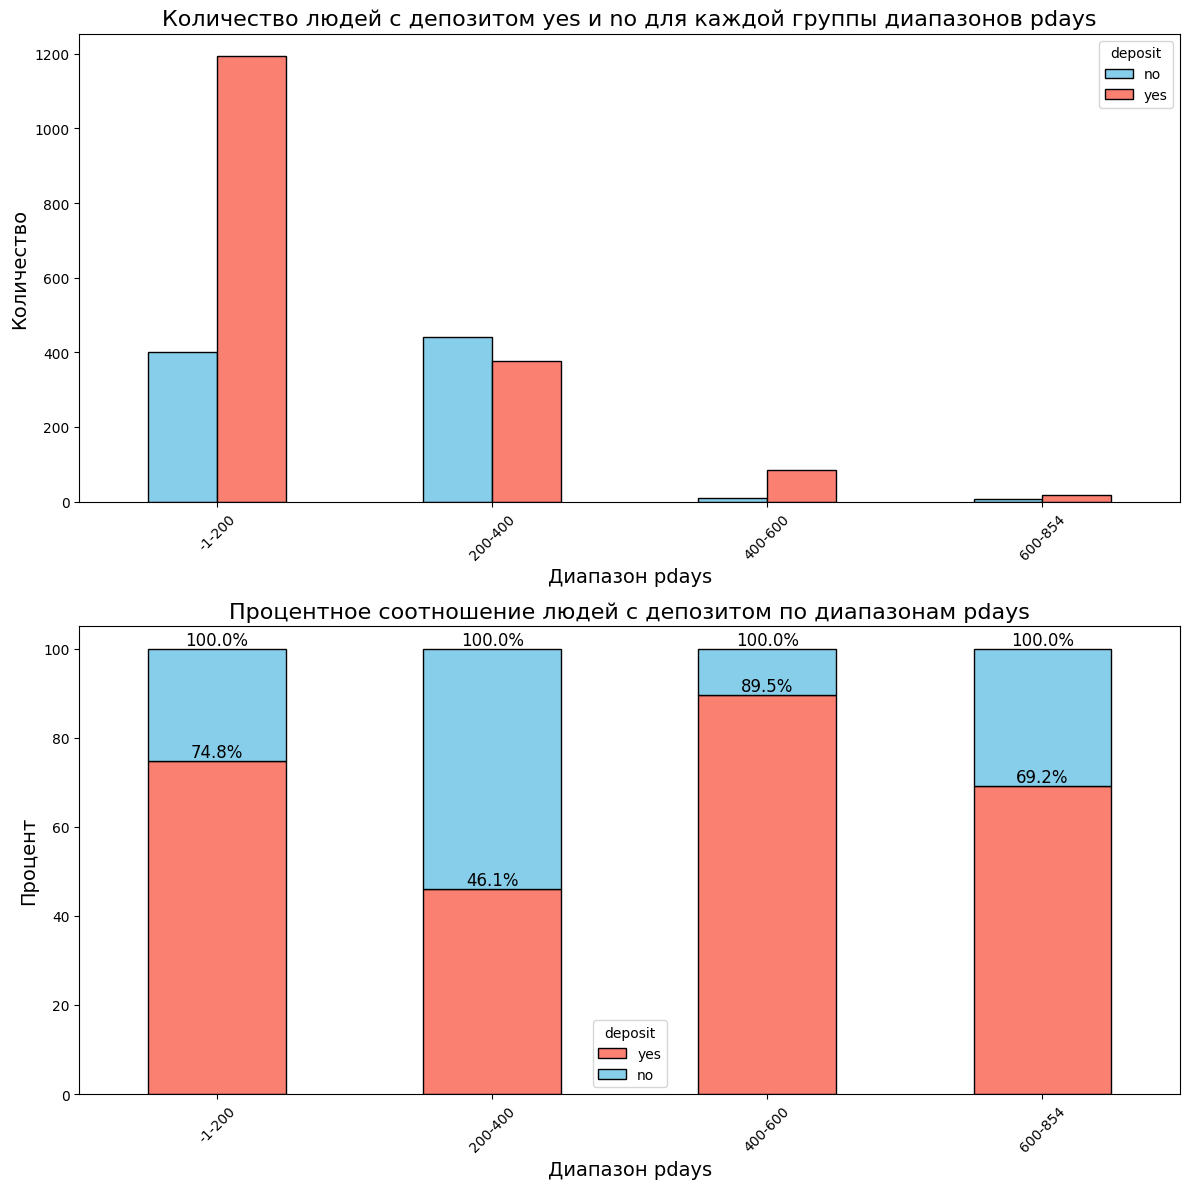

In [82]:


# # Разделение pdays на диапазоны, учитывая статистические данные
# pdays_bins = pd.cut(df['pdays'], bins=[-2, 0, 2, 10, 100, 854], 
#                     labels=['-1', '0-2', '3-10', '11-100', '101-854'])

# Разделение pdays на диапазоны
pdays_bins = pd.cut(df['pdays'], bins=[-1, 200, 400, 600, 854], 
                    labels=['-1-200', '200-400', '400-600', '600-854'])

# Группировка данных по 'pdays_bins' и 'deposit' для подсчета количества (count) в каждой категории
grouped_pdays_deposit = df.groupby([pdays_bins, 'deposit']).size().unstack(fill_value=0)

# Создание сводной таблицы для процентного соотношения по диапазонам pdays
pdays_deposit_counts = df.groupby([pdays_bins, 'deposit']).size().unstack(fill_value=0)
pdays_deposit_percentages = (pdays_deposit_counts.div(pdays_deposit_counts.sum(axis=1), axis=0) * 100).reset_index()

# Пересортировка столбцов, чтобы "yes" был первым
pdays_deposit_percentages = pdays_deposit_percentages[['pdays', 'yes', 'no']]

# Создание графиков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Верхний график - количество людей с депозитом yes и no для каждой группы диапазонов pdays
grouped_pdays_deposit.plot(kind='bar', stacked=False, ax=axes[0], color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_title('Количество людей с депозитом yes и no для каждой группы диапазонов pdays', fontsize=16)
axes[0].set_xlabel('Диапазон pdays', fontsize=14)
axes[0].set_ylabel('Количество', fontsize=14)
axes[0].legend(title='deposit', loc='upper right')
axes[0].tick_params(axis='x', rotation=45)

# Нижний график - процентное соотношение людей с депозитом для каждого диапазона pdays
pdays_deposit_percentages.plot(kind='bar', x='pdays', stacked=True, color=['salmon', 'skyblue'], edgecolor='black', ax=axes[1])
axes[1].set_title('Процентное соотношение людей с депозитом по диапазонам pdays', fontsize=16)
axes[1].set_xlabel('Диапазон pdays', fontsize=14)
axes[1].set_ylabel('Процент', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
for container in axes[1].containers:
    axes[1].bar_label(container, label_type='edge', fontsize=12, fmt='%.1f%%')

# Показать графики
plt.tight_layout()
plt.show()



pdays - следующий признак 

Имя | Процент | MCH
|--|--|--|
-1-200 | 74.8% | M




Берем одну категорию, так как во всех остальных случаев приоблодает больше отказов, чем положителных депозитов


### previous

In [83]:
df['previous'].describe()

count    10105.000000
mean         0.816230
std          2.243795
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         58.000000
Name: previous, dtype: float64

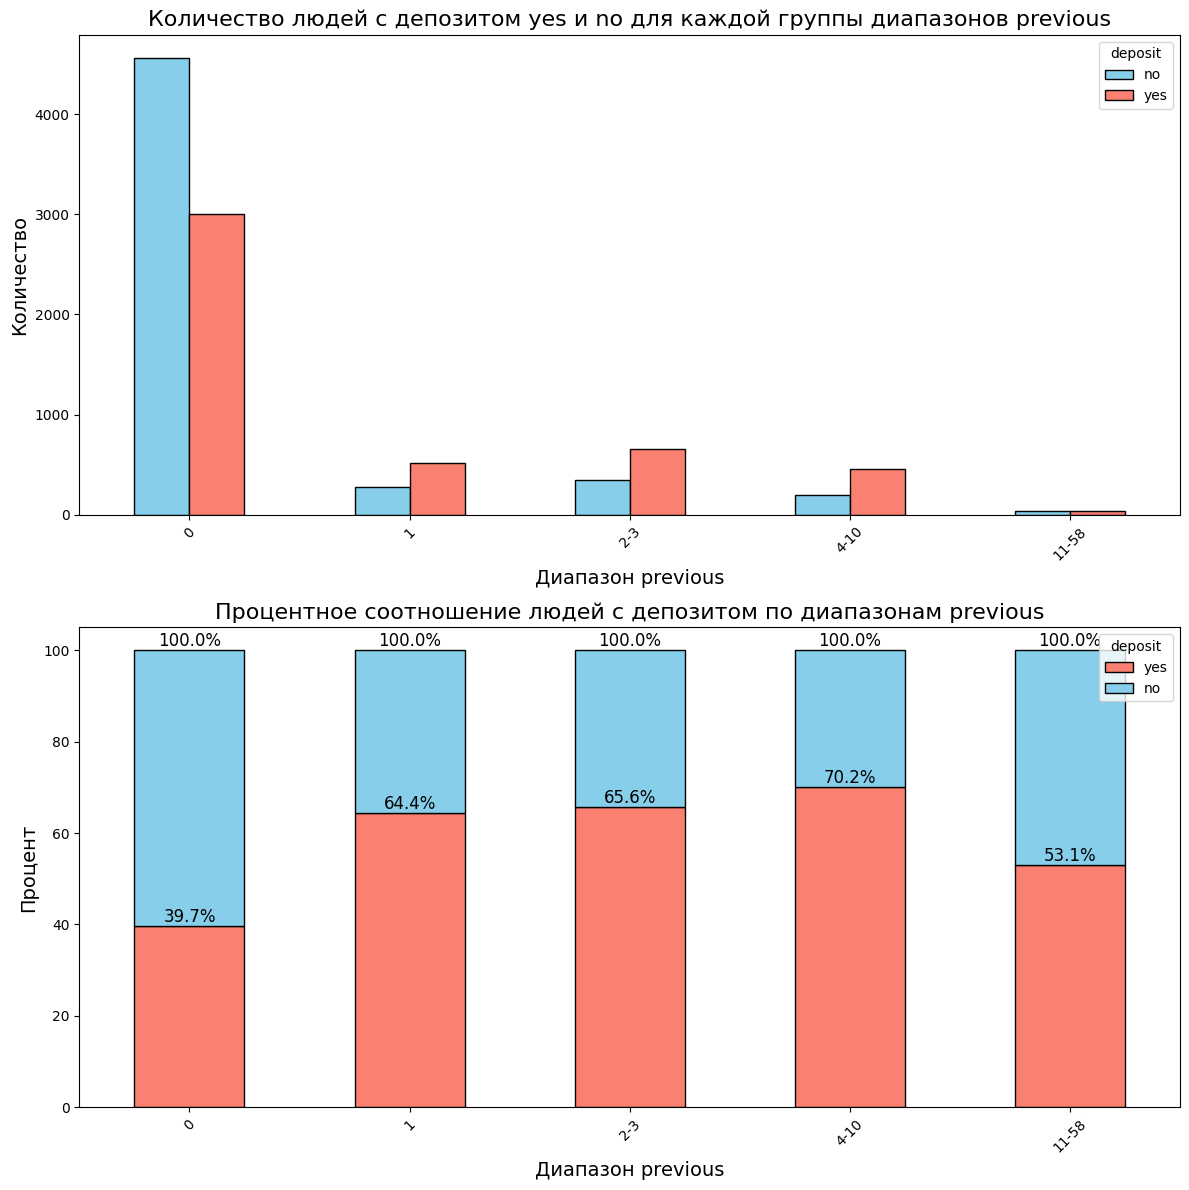

In [84]:
# # Разделение previous на диапазоны
# previous_bins = pd.cut(df['previous'], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 58], 
#                       labels=['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-58'])



# Разделение previous на диапазоны, учитывая статистические данные
previous_bins = pd.cut(df['previous'], bins=[-1, 0, 1, 3, 10, 58], 
                       labels=['0', '1', '2-3', '4-10', '11-58'])

# Группировка данных по 'previous_bins' и 'deposit' для подсчета количества (count) в каждой категории
grouped_previous_deposit = df.groupby([previous_bins, 'deposit']).size().unstack(fill_value=0)

# Создание сводной таблицы для процентного соотношения по диапазонам previous
previous_deposit_counts = df.groupby([previous_bins, 'deposit']).size().unstack(fill_value=0)
previous_deposit_percentages = (previous_deposit_counts.div(previous_deposit_counts.sum(axis=1), axis=0) * 100).reset_index()

# Пересортировка столбцов, чтобы "yes" был первым
previous_deposit_percentages = previous_deposit_percentages[['previous', 'yes', 'no']]

# Создание графиков
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Верхний график - количество людей с депозитом yes и no для каждой группы диапазонов previous
grouped_previous_deposit.plot(kind='bar', stacked=False, ax=axes[0], color=['skyblue', 'salmon'], edgecolor='black')
axes[0].set_title('Количество людей с депозитом yes и no для каждой группы диапазонов previous', fontsize=16)
axes[0].set_xlabel('Диапазон previous', fontsize=14)
axes[0].set_ylabel('Количество', fontsize=14)
axes[0].legend(title='deposit', loc='upper right')
axes[0].tick_params(axis='x', rotation=45)

# Нижний график - процентное соотношение людей с депозитом для каждого диапазона previous
previous_deposit_percentages.plot(kind='bar', x='previous', stacked=True, color=['salmon', 'skyblue'], edgecolor='black', ax=axes[1])
axes[1].set_title('Процентное соотношение людей с депозитом по диапазонам previous', fontsize=16)
axes[1].set_xlabel('Диапазон previous', fontsize=14)
axes[1].set_ylabel('Процент', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
for container in axes[1].containers:
    axes[1].bar_label(container, label_type='edge', fontsize=12, fmt='%.1f%%')

# Показать графики
plt.tight_layout()
plt.show()



previous - следующий признак 

Имя | Процент | MCH
|--|--|--|
4-10 | 70.2% | H
2-3 | 65.6% | H
1 | 64.4% | H 



Берем три категории, так как во всех остальных случаев приоблодает больше отказов, чем положителных депозитов


## Общий вывод : 




# идеальный вариант
# Фильтрация данных по нескольким признакам
filtered_df = df[
    (df['poutcome'] == 'success') &
    (df['month'].isin(['dec', 'mar', 'oct', 'sep'])) &
    (df['duration'].between(490, 3881))
]

# Создание нового признака и установка значений
df['legend'] = 0
df.loc[filtered_df.index, 'legend'] = 1


### Задание 11

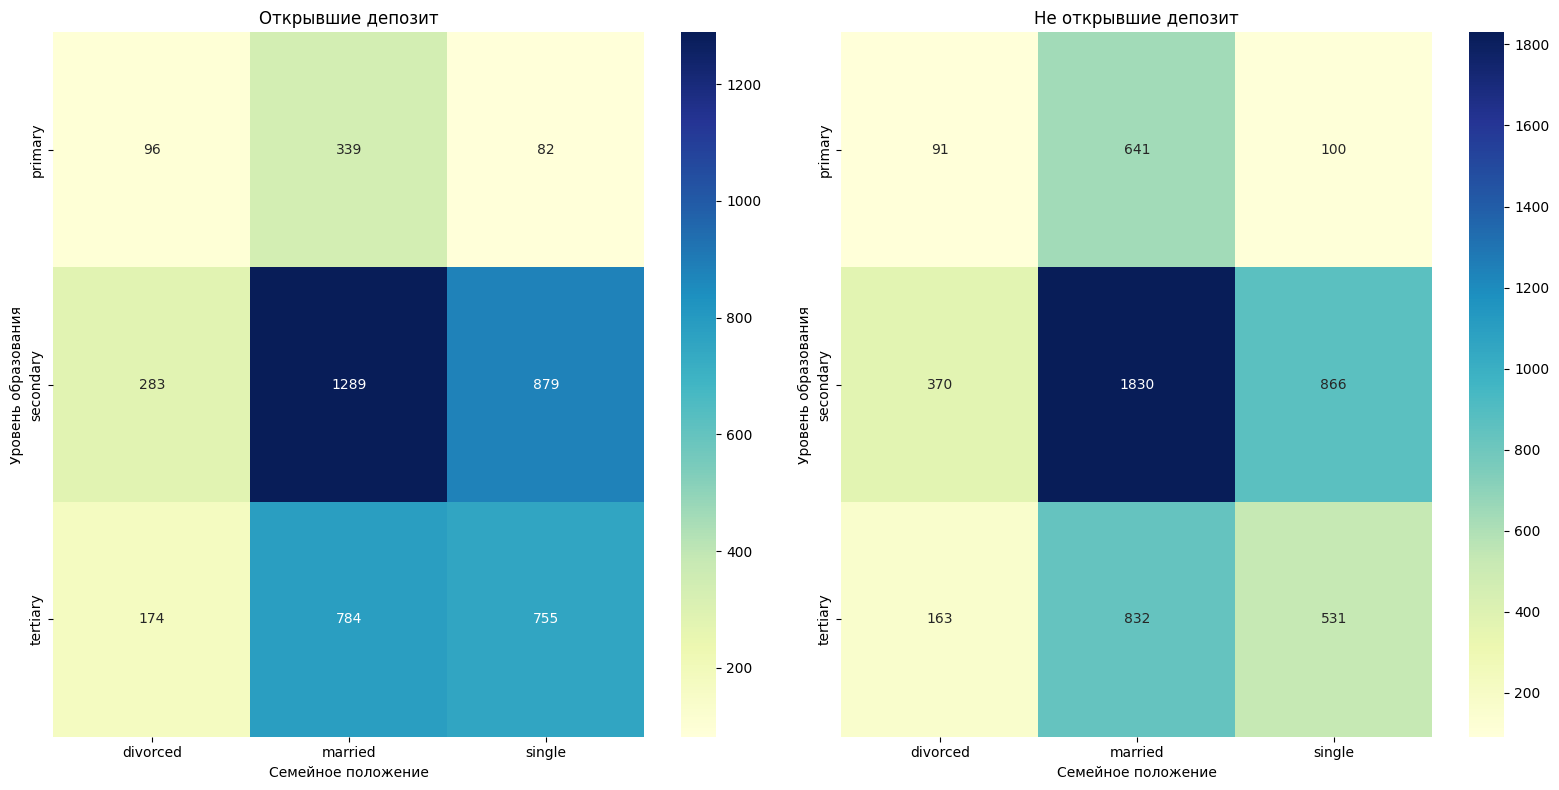

In [85]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)


# Разделение таблицы на две части
df_yes = df[df['deposit'] == 'yes']
df_no = df[df['deposit'] == 'no']

# Построение сводных таблиц
pivot_yes = df_yes.pivot_table(index='education', columns='marital', aggfunc='size', fill_value=0)
pivot_no = df_no.pivot_table(index='education', columns='marital', aggfunc='size', fill_value=0)

# Построение тепловых карт
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

sns.heatmap(pivot_yes, annot=True, fmt="d", cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Открывшие депозит')
axes[0].set_xlabel('Семейное положение')
axes[0].set_ylabel('Уровень образования')

sns.heatmap(pivot_no, annot=True, fmt="d", cmap="YlGnBu", ax=axes[1])
axes[1].set_title('Не открывшие депозит')
axes[1].set_xlabel('Семейное положение')
axes[1].set_ylabel('Уровень образования')

plt.tight_layout()
plt.show()


## Часть 3: преобразование данных

### Задание 1

In [86]:
# преобразуйте уровни образования

df['education'] = LabelEncoder().fit_transform(df['education'])
df['education'].sum()

11995

### Задания 2 и 3

In [87]:
# Преобразовываем уровень возраст 
df['age_category'] = LabelEncoder().fit_transform(df['age_category'])


In [88]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# Преобразование столбца 'deposit' с использованием map()
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})



# Приобразувываю значения из yes и no в 1 и 0 
df['default'] = df['default'].map({'yes': 1, 'no': 0})
df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
df['loan'] = df['loan'].map({'yes': 1, 'no': 0})

# Высчитываю среднее арифметическое у каждого признака
per = df['loan'].mean()
vtor = df['housing'].mean()
tret = df['default'].mean()

# Отображаю заданный ответ
otvet = round(per + vtor + tret,3)
otvet

0.635

### Задание 4

In [89]:
# создайте дамми-переменные
# Создание dummy-переменных
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_category       10105 non-null  int32  
 13  job_admin.         10105 non-null  bool   
 14  job_blue-collar    10105 non-null  bool   
 15  job_entrepreneur   10105 non-null  bool   
 16  job_housemaid      10105 no

### Задания 5 и 6

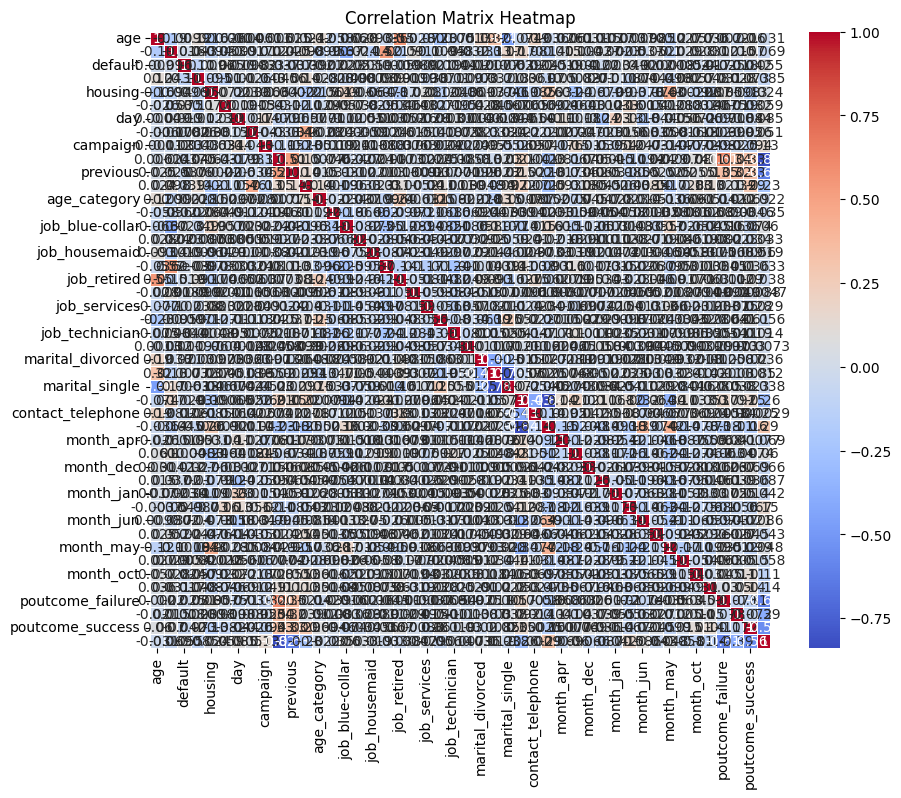

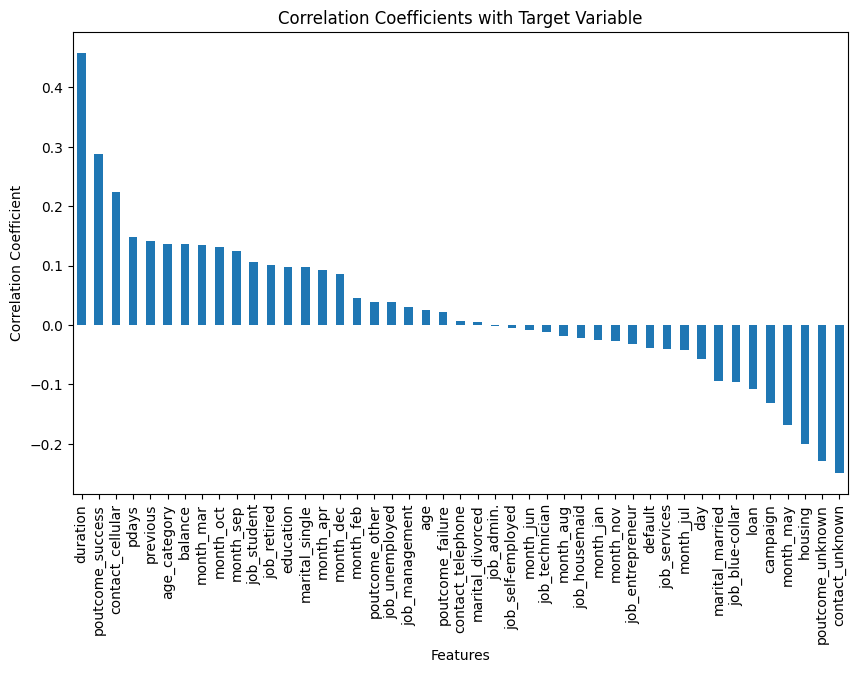

Pairs of features with strong correlation (>= 0.9 or <= -0.9):
Empty DataFrame
Columns: [Feature 1, Feature 2, Correlation]
Index: []


In [90]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

# Вычисление матрицы корреляций
corr_matrix = df.corr()

# Построение тепловой карты для матрицы корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Вычисление ранжированных коэффициентов корреляции для целевой переменной
corr_target = corr_matrix['deposit'].sort_values(ascending=False)

# Построение столбчатой диаграммы для ранжированных коэффициентов корреляции
plt.figure(figsize=(10, 6))
corr_target.drop('deposit').plot(kind='bar')
plt.title('Correlation Coefficients with Target Variable')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.show()

# Поиск признаков с корреляцией >= 0.9 или <= -0.9
strong_corr = corr_matrix[(corr_matrix >= 0.9) | (corr_matrix <= -0.9)]
strong_corr_pairs = strong_corr.stack().reset_index()
strong_corr_pairs = strong_corr_pairs[strong_corr_pairs['level_0'] != strong_corr_pairs['level_1']]
strong_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

print("Pairs of features with strong correlation (>= 0.9 or <= -0.9):")
print(strong_corr_pairs)

### Задания 7 и 8

In [91]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

# Посмотрим на размерности выборок
print(f'Размерность обучающей выборки {X_train.shape}')
print(f'Размерность тестовой выборки {X_test.shape}')



Размерность обучающей выборки (6770, 45)
Размерность тестовой выборки (3335, 45)


In [92]:
# рассчитайте необходимые показатели

from sklearn.preprocessing import MinMaxScaler
# Разделение данных на обучающую и тестовую выборки
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)

# Применение MinMaxScaler к целевой переменной
scaler = MinMaxScaler()
train_df['deposit'] = scaler.fit_transform(train_df[['deposit']])
test_df['deposit'] = scaler.transform(test_df[['deposit']])

# Вычисление среднего значения нормализованной целевой переменной на тестовой выборке
average_deposit_test = test_df['deposit'].mean()

# Округление до двух знаков после точки
average_deposit_test_rounded = round(average_deposit_test, 2)

print("Среднее значение целевой переменной на тестовой выборке после нормализации:", average_deposit_test_rounded)

Среднее значение целевой переменной на тестовой выборке после нормализации: 0.47


### Задание 9

In [93]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

# Применение SelectKBest для отбора 15 лучших признаков
selector = SelectKBest(score_func=f_classif, k=15)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Получение отобранных признаков
selected_features = X_train.columns[selector.get_support()]

print("Отобранные признаки:")
print(selected_features)

Отобранные признаки:
Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_category', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


### Задание 10

In [94]:
# нормализуйте данные с помощью minmaxsxaler

# Нормализация предикторов с использованием MinMaxScaler
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_selected)
X_test_normalized = scaler.transform(X_test_selected)

# Выводим формы для проверки
print("Форма нормализованной обучающей выборки:", X_train_normalized.shape)
print("Форма нормализованной тестовой выборки:", X_test_normalized.shape)

# Вычисление среднего арифметического для первого предиктора
mean_first_predictor = X_test_normalized[:, 0].mean()

# Округление до двух знаков после точки-разделителя
mean_first_predictor_rounded = round(mean_first_predictor, 2)

print("Среднее арифметическое для первого предиктора из тестовой выборки:", mean_first_predictor_rounded)

Форма нормализованной обучающей выборки: (6770, 15)
Форма нормализованной тестовой выборки: (3335, 15)
Среднее арифметическое для первого предиктора из тестовой выборки: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [95]:
# обучите логистическую регрессию и рассчитайте метрики качества

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Применение SelectKBest для отбора 15 лучших признаков
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X, y)

# Нормализация предикторов с использованием MinMaxScaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_selected)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Обучение модели логистической регрессии
model = LogisticRegression(solver='sag', random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Вычисление accuracy на тестовой выборке
accuracy = accuracy_score(y_test, y_pred)

# Ответ округляем до двух знаков после точки-разделителя
accuracy_rounded = round(accuracy, 2)

print("Accuracy модели логистической регрессии на тестовой выборке:", accuracy_rounded)



Accuracy модели логистической регрессии на тестовой выборке: 0.83


### Задания 2,3,4

Accuracy модели решающих деревьев на тестовой выборке: 0.75
Оптимальная глубина дерева: 6
Accuracy на тестовой выборке для оптимальной глубины дерева: 0.8


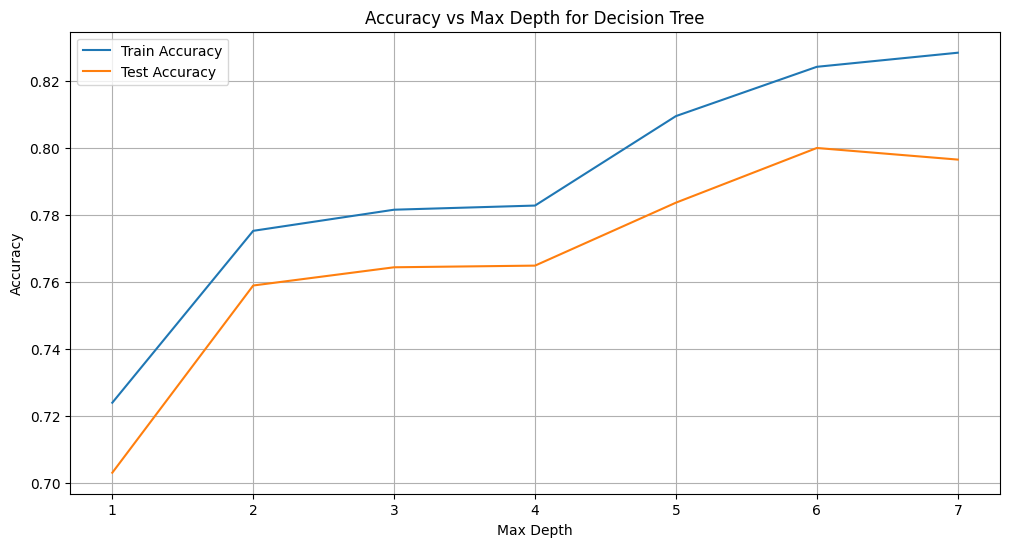

In [96]:
# обучите решающие деревья, настройте максимальную глубину

from sklearn.tree import DecisionTreeClassifier

# Обучение модели решающих деревьев
dt_model = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_dt = dt_model.predict(X_test)

# Вычисление accuracy на тестовой выборке
accuracy_dt = accuracy_score(y_test, y_pred_dt)

# Ответ округляем до двух знаков после точки-разделителя
accuracy_dt_rounded = round(accuracy_dt, 2)

print("Accuracy модели решающих деревьев на тестовой выборке:", accuracy_dt_rounded)

# Перебор различных значений максимальной глубины дерева
max_depths = range(1, 8)
train_accuracies = []
test_accuracies = []

for max_depth in max_depths:
    dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    dt_model.fit(X_train, y_train)
    y_train_pred = dt_model.predict(X_train)
    y_test_pred = dt_model.predict(X_test)
    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    test_accuracies.append(accuracy_score(y_test, y_test_pred))

# Нахождение оптимальной глубины дерева
optimal_depth = max_depths[test_accuracies.index(max(test_accuracies))]
optimal_accuracy = max(test_accuracies)

# Вывод результатов
print(f"Оптимальная глубина дерева: {optimal_depth}")
print(f"Accuracy на тестовой выборке для оптимальной глубины дерева: {round(optimal_accuracy, 2)}")

# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(max_depths, train_accuracies, label='Train Accuracy')
plt.plot(max_depths, test_accuracies, label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth for Decision Tree')
plt.legend()
plt.grid(True)
plt.show()


### Задание 5

In [97]:
# подберите оптимальные параметры с помощью gridsearch

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

# Параметры для перебора в GridSearch
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}

# Инициализация модели
dt_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Настройка GridSearchCV
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

# Обучение GridSearchCV
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

# Предсказание на тестовой выборке с использованием наилучшей модели
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Вычисление метрики F1 на тестовой выборке
f1 = f1_score(y_test, y_pred)

# Округление до двух знаков после точки-разделителя
f1_rounded = round(f1, 2)

print("F1 метрика на тестовой выборке для наилучшей комбинации параметров:", f1_rounded)


Лучшие параметры: {'max_depth': 7, 'min_samples_split': 10}
F1 метрика на тестовой выборке для наилучшей комбинации параметров: 0.78


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [98]:
# обучите на ваших данных случайный лес


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score

# Обучение модели случайного леса с заданными параметрами
rf_model = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = rf_model.predict(X_test)

# Вычисление метрик accuracy и recall на тестовой выборке
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Округление до двух знаков после точки-разделителя
accuracy_rounded = round(accuracy, 2)
recall_rounded = round(recall, 2)

print("Accuracy модели случайного леса на тестовой выборке:", accuracy_rounded)
print("Recall модели случайного леса на тестовой выборке:", recall_rounded)

# Accuracy модели случайного леса на тестовой выборке: 0.83
# Recall модели случайного леса на тестовой выборке: 0.84


Accuracy модели случайного леса на тестовой выборке: 0.82
Recall модели случайного леса на тестовой выборке: 0.85


### Задания 2 и 3

In [99]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

from sklearn.ensemble import GradientBoostingClassifier

# Обучение модели градиентного бустинга с заданными параметрами
gb_model = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = gb_model.predict(X_test)

# Вычисление метрики F1 на тестовой выборке
f1 = f1_score(y_test, y_pred)

# Округление до двух знаков после точки-разделителя
f1_rounded = round(f1, 2)

print("F1 метрика на тестовой выборке для модели градиентного бустинга:", f1_rounded)

# F1 метрика на тестовой выборке для модели градиентного бустинга: 0.82


# Какая модель даёт более качественный прогноз (если посмотреть известные вам метрики в целом)?

# ```Случайный лес```


F1 метрика на тестовой выборке для модели градиентного бустинга: 0.82


### Задание 4

In [100]:
# объедините уже известные вам алгоритмы с помощью стекинга 

from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import precision_score

# Инициализация базовых моделей
dt_model = DecisionTreeClassifier(criterion='entropy', random_state=42)
log_reg_model = LogisticRegression(solver='saga', random_state=42, max_iter=1000)
gb_model = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

# Создание стекинг-модели
estimators = [
    ('decision_tree', dt_model),
    ('logistic_regression', log_reg_model),
    ('gradient_boosting', gb_model)
]
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(solver='saga', random_state=42, max_iter=1000),
    n_jobs=-1
)

# Обучение стекинг-модели
stacking_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = stacking_model.predict(X_test)

# Вычисление метрики precision на тестовой выборке
precision = precision_score(y_test, y_pred)

# Округление до двух знаков после точки-разделителя
precision_rounded = round(precision, 2)

print("Precision модели стекинга на тестовой выборке:", precision_rounded)

# Precision модели стекинга на тестовой выборке: 0.82

Precision модели стекинга на тестовой выборке: 0.8


### Задание 5

In [101]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга


# Обучение модели градиентного бустинга с заданными параметрами
gb_model = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train, y_train)

# Извлечение важности признаков
feature_importances = gb_model.feature_importances_

# Получение имен признаков
feature_names = np.array(X.columns[selector.get_support()])

# Создание DataFrame для отображения важности признаков
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Сортировка признаков по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Выбор трех наиболее значимых признаков
top_features = importance_df.head(3)

print("Три наиболее значимых признака:")
print(top_features)


# Три наиболее значимых признака:
#              Feature  Importance
# 2           duration    0.503805
# 13  poutcome_success    0.115602
# 8    contact_unknown    0.075658

Три наиболее значимых признака:
             Feature  Importance
2           duration    0.503805
13  poutcome_success    0.115602
8    contact_unknown    0.075658


### Задания 6,7,8

In [102]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

import optuna

def objective(trial):
    # Определение гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # Обучение модели случайного леса с заданными гиперпараметрами
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        criterion='gini',
        random_state=42
    )
    model.fit(X_train, y_train)

    # Предсказание на тестовой выборке
    y_pred = model.predict(X_test)

    # Оценка метрики F1
    f1 = f1_score(y_test, y_pred)

    return f1

# Создание исследования
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Лучшие гиперпараметры
best_params = study.best_params
print("Лучшие гиперпараметры: ", best_params)

# Обучение модели с лучшими гиперпараметрами
best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion='gini',
    random_state=42
)
best_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_best = best_model.predict(X_test)

# Оценка метрик F1 и accuracy
f1_best = f1_score(y_test, y_pred_best)
accuracy_best = accuracy_score(y_test, y_pred_best)

# Округление до двух знаков после точки-разделителя
f1_best_rounded = round(f1_best, 2)
accuracy_best_rounded = round(accuracy_best, 2)

print("F1 на тестовой выборке:", f1_best_rounded)
print("Accuracy на тестовой выборке:", accuracy_best_rounded)

# Лучшие гиперпараметры:  {'n_estimators': 196, 'max_depth': 27, 'min_samples_leaf': 4}
# F1 на тестовой выборке: 0.83
# Accuracy на тестовой выборке: 0.83


[I 2024-06-19 16:08:09,353] A new study created in memory with name: no-name-45d4ecf8-96b2-46e0-99c0-6a2cc8c62050
[I 2024-06-19 16:08:11,243] Trial 0 finished with value: 0.8208032955715757 and parameters: {'n_estimators': 134, 'max_depth': 21, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8208032955715757.
[I 2024-06-19 16:08:13,152] Trial 1 finished with value: 0.820618556701031 and parameters: {'n_estimators': 119, 'max_depth': 23, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8208032955715757.
[I 2024-06-19 16:08:16,888] Trial 2 finished with value: 0.8217213114754098 and parameters: {'n_estimators': 177, 'max_depth': 21, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8217213114754098.
[I 2024-06-19 16:08:18,698] Trial 3 finished with value: 0.8208032955715757 and parameters: {'n_estimators': 117, 'max_depth': 20, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.8217213114754098.
[I 2024-06-19 16:08:21,296] Trial 4 finished with value: 0.818322182192485

Лучшие гиперпараметры:  {'n_estimators': 146, 'max_depth': 15, 'min_samples_leaf': 4}
F1 на тестовой выборке: 0.83
Accuracy на тестовой выборке: 0.83
